In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from transformers import RobertaTokenizer, RobertaModel
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import DataLoader, Subset
from scipy.stats import pearsonr
from tqdm import tqdm
from sklearn.exceptions import FitFailedWarning
import warnings
from sklearn.model_selection import ParameterSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib
from sklearn.base import clone


In [1]:
import numpy as np
import pandas as pd

# 读取 .npy 文件
labels = np.load("all_fold_labels.npy", allow_pickle=True)

probs = np.load("all_fold_probs.npy", allow_pickle=True)

# 确保数据是一维的
labels = np.concatenate(labels) if isinstance(labels, list) else labels.ravel()

probs = np.concatenate(probs) if isinstance(probs, list) else probs.ravel()

# 创建 DataFrame
df = pd.DataFrame({
    "y": labels,
    "y_prob": probs
})

# 保存为 CSV 文件
csv_filename = "ChemBERTa_misclassified_samples.csv"
df.to_csv(csv_filename, index=False)

print(f"CSV 文件已保存: {csv_filename}")


CSV 文件已保存: ChemBERTa_misclassified_samples.csv


In [2]:
import pandas as pd
from rdkit import Chem

# 读取数据
# 数据预处理
df = pd.read_csv('imputed_selected_features_Flam.csv')
labels = df['Flammability'].values
smiles_list = df['SMILES'].tolist()



In [3]:
import torch

# 检查是否有可用的 GPU
if torch.cuda.is_available():
    print("CUDA 可用，GPU 可用。")
    print(f"CUDA 版本: {torch.version.cuda}")
    print(f"GPU 数量: {torch.cuda.device_count()}")
    print(f"当前设备名称: {torch.cuda.get_device_name(0)}")
    print(f"当前设备总内存: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("CUDA 不可用，仅支持 CPU。")


CUDA 可用，GPU 可用。
CUDA 版本: 12.1
GPU 数量: 1
当前设备名称: NVIDIA vGPU-32GB
当前设备总内存: 31.48 GB


In [9]:
smiles_data=smiles_list

In [4]:
# 数据增强函数：简单的 SMILES 序列翻转
def augment_smiles(smiles):
    """简单的数据增强方法，例如旋转 SMILES 字符串"""
    if random.random() > 0.5:
        return smiles[::-1]  # 翻转字符串
    return smiles



class SMILES_Dataset(Dataset):
    def __init__(self, smiles, class_labels):
        self.smiles = smiles  # SMILES字符串列表
        self.class_labels = class_labels  # 分类任务标签

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        # smiles = augment_smiles(self.smiles[idx])  # 如果需要数据增强，可以启用这行
        smiles = self.smiles[idx]  # 获取单个SMILES
        class_label = self.class_labels[idx]  # 获取对应的分类标签
        tokens = tokenizer(smiles, padding='max_length', truncation=True, max_length=128, return_tensors="pt")
        return tokens, torch.tensor(class_label, dtype=torch.long)



class ChemBERTa_Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ChemBERTa_Classifier, self).__init__()
        # 加载预训练的ChemBERTa模型
        self.chemberta = chemberta_model  # 假设chemberta_model已定义
        hidden_size = self.chemberta.config.hidden_size  # 一般为768

        # 分类任务的全连接层
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, tokens):
        output = self.chemberta(**tokens)
        cls_embedding = output.last_hidden_state[:, 0, :]  # [CLS] token 嵌入
        class_output = self.classifier(cls_embedding)  # 分类任务输出
        return class_output

In [5]:
# 加载 ChemBERTa 模型和 tokenizer
model_name = "../ChemBERTa"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
chemberta_model = RobertaModel.from_pretrained(model_name)

In [6]:
# 假设 num_classes 已经定义，表示分类任务的类别数
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 使用类别数来初始化分类器模型
model = ChemBERTa_Classifier(num_classes=2).to(device)  # 这里假设是4分类任务，您可以根据需要调整类别数

In [7]:
from torch.utils.data import DataLoader, random_split
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import joblib

# 定义 K 折交叉验证的折数
K_FOLDS = 5
num_epochs = 50
batch_size = 32

# 分类任务的损失函数
class_criterion = nn.CrossEntropyLoss()

# 记录所有折的训练损失和准确率
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []
all_fold_preds = []
all_fold_probs = []
all_fold_labels = []

# 使用 Stratified K-Fold 交叉验证
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=22)

for fold, (train_idx, val_idx) in enumerate(skf.split(smiles_data, labels)):
    print(f"\n===== Fold {fold+1}/{K_FOLDS} =====")

    # 创建本折的训练集和验证集
    train_dataset = Subset(SMILES_Dataset(smiles_data, labels), train_idx)
    val_dataset = Subset(SMILES_Dataset(smiles_data, labels), val_idx)

    # 生成数据加载器
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True)

    # 初始化模型（确保每一折都有一个新的模型）
    # 假设 num_classes 已经定义，表示分类任务的类别数
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # 使用类别数来初始化分类器模型
    # 加载 ChemBERTa 模型和 tokenizer
    model_name = "../ChemBERTa"
    tokenizer = RobertaTokenizer.from_pretrained(model_name)
    chemberta_model = RobertaModel.from_pretrained(model_name)
    model = ChemBERTa_Classifier(num_classes=2).to(device)  # 这里假设是4分类任务，您可以根据需要调整类别数
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

    # 记录当前折的训练和验证损失、准确率
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # 开始训练
    for epoch in range(num_epochs):
        model.train()
        running_class_loss = 0.0
        correct_class_preds = 0
        total_class_preds = 0

        # 训练过程
        train_loader_tqdm = tqdm(train_loader, desc=f"Fold {fold+1} | Epoch [{epoch+1}/{num_epochs}] - Training")
        for tokens, class_labels in train_loader_tqdm:
            tokens = {key: val.squeeze(1).to(device) for key, val in tokens.items()}
            class_labels = class_labels.to(device)

            # 前向传播
            optimizer.zero_grad()
            class_output = model(tokens)

            # 计算损失
            class_loss = class_criterion(class_output, class_labels)
            class_loss.backward()
            optimizer.step()

            running_class_loss += class_loss.item()

            # 计算分类准确率
            _, predicted = torch.max(class_output, 1)
            correct_class_preds += (predicted == class_labels).sum().item()
            total_class_preds += class_labels.size(0)

            # 在 tqdm 显示分类损失
            train_loader_tqdm.set_postfix({'Class Loss': class_loss.item()})

        avg_class_loss = running_class_loss / len(train_loader)
        train_accuracy = correct_class_preds / total_class_preds
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Class Loss: {avg_class_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        # 保存训练损失和准确率
        train_losses.append(avg_class_loss)
        train_accuracies.append(train_accuracy)

        # 评估模型
        model.eval()
        val_class_loss = 0.0
        correct_class_preds = 0
        total_class_preds = 0

        val_loader_tqdm = tqdm(val_loader, desc=f"Fold {fold+1} | Epoch [{epoch+1}/{num_epochs}] - Validation")
        with torch.no_grad():
            for tokens, class_labels in val_loader_tqdm:
                tokens = {key: val.squeeze(1).to(device) for key, val in tokens.items()}
                class_labels = class_labels.to(device)

                # 前向传播
                class_output = model(tokens)

                # 计算损失
                class_loss = class_criterion(class_output, class_labels)
                val_class_loss += class_loss.item()

                # 计算分类准确率
                _, predicted = torch.max(class_output, 1)
                correct_class_preds += (predicted == class_labels).sum().item()
                total_class_preds += class_labels.size(0)

            avg_val_class_loss = val_class_loss / len(val_loader)
            val_accuracy = correct_class_preds / total_class_preds
            print(f"Epoch [{epoch+1}/{num_epochs}], Val Class Loss: {avg_val_class_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

            # 保存验证损失和准确率
            val_losses.append(avg_val_class_loss)
            val_accuracies.append(val_accuracy)

    
    # 确保模型在评估模式
    model.eval()
    
    # 存储真实标签和预测结果
    all_preds = []
    all_probs = []
    all_labels = []
    
    # 遍历测试集进行预测
    test_loader_tqdm = tqdm(val_loader, desc="Testing")
    with torch.no_grad():
        for tokens, class_labels in test_loader_tqdm:
            tokens = {key: val.squeeze(1).to(device) for key, val in tokens.items()}
            class_labels = class_labels.to(device)
    
            # 预测
            class_output = model(tokens)
            probs = torch.softmax(class_output, dim=1)  # 获取概率分布
            _, predicted = torch.max(class_output, 1)  # 获取类别预测结果
    
            all_probs.extend(probs[:, 1].cpu().numpy())  # 取出正类的概率
            all_preds.extend(predicted.cpu().numpy())  # 取出预测类别
            all_labels.extend(class_labels.cpu().numpy())  # 真实标签
    
    # 转换为 numpy 数组
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    all_fold_preds.append(all_preds)
    all_fold_probs.append(all_probs)
    all_fold_labels.append(all_labels)
    
    
    from sklearn.metrics import precision_recall_curve, auc
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    roc_auc = roc_auc_score(all_labels, all_probs)
    # 计算 Precision-Recall 曲线
    precisions, recalls, _ = precision_recall_curve(all_labels, all_probs)
    
    # 计算 PR-AUC
    pr_auc = auc(recalls, precisions)
    
    # 输出所有评估指标
    print(f"Fold {fold+1}Test Accuracy: {accuracy:.4f}")
    print(f"Fold {fold+1}Test Precision: {precision:.4f}")
    print(f"Fold {fold+1}Test Recall: {recall:.4f}")
    print(f"Fold {fold+1}Test F1 Score: {f1:.4f}")
    print(f"Fold {fold+1}Test ROC-AUC: {roc_auc:.4f}")
    print(f"Fold {fold+1}Test PR-AUC: {pr_auc:.4f}")  # 输出 PR-AUC
    
    # 计算混淆矩阵
    conf_matrix_test = confusion_matrix(all_labels, all_preds)
    print(conf_matrix_test)

    # 保存所有折的训练过程数据
    results = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies
    }


    joblib.dump(results, f"Fold {fold+1}  cross_validation_results.pkl")
    # 保存当前折的模型
    model_path = f"bert_classifier_fold{fold+1}.pt"
    torch.save(model.state_dict(), model_path)
    print(f"Model for Fold {fold+1} saved to {model_path}\n")

# 结束 K 折交叉验证
print("\n===== K-Fold Cross-Validation Completed! =====")




===== Fold 1/5 =====


Fold 1 | Epoch [1/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 13.68it/s, Class Loss=0.721]


Epoch [1/50], Train Class Loss: 0.7375, Train Accuracy: 0.5607


Fold 1 | Epoch [1/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.23it/s]


Epoch [1/50], Val Class Loss: 0.6660, Val Accuracy: 0.6328


Fold 1 | Epoch [2/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.44it/s, Class Loss=0.765]


Epoch [2/50], Train Class Loss: 0.7279, Train Accuracy: 0.5570


Fold 1 | Epoch [2/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.60it/s]


Epoch [2/50], Val Class Loss: 0.6356, Val Accuracy: 0.6719


Fold 1 | Epoch [3/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.54it/s, Class Loss=0.655]


Epoch [3/50], Train Class Loss: 0.7453, Train Accuracy: 0.5478


Fold 1 | Epoch [3/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.16it/s]


Epoch [3/50], Val Class Loss: 0.6288, Val Accuracy: 0.6797


Fold 1 | Epoch [4/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.55it/s, Class Loss=0.69] 


Epoch [4/50], Train Class Loss: 0.7205, Train Accuracy: 0.5533


Fold 1 | Epoch [4/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.71it/s]


Epoch [4/50], Val Class Loss: 0.6274, Val Accuracy: 0.6953


Fold 1 | Epoch [5/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.58it/s, Class Loss=0.602]


Epoch [5/50], Train Class Loss: 0.7267, Train Accuracy: 0.5478


Fold 1 | Epoch [5/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.53it/s]


Epoch [5/50], Val Class Loss: 0.6127, Val Accuracy: 0.7109


Fold 1 | Epoch [6/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.57it/s, Class Loss=0.782]


Epoch [6/50], Train Class Loss: 0.7210, Train Accuracy: 0.5496


Fold 1 | Epoch [6/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.67it/s]


Epoch [6/50], Val Class Loss: 0.6224, Val Accuracy: 0.6953


Fold 1 | Epoch [7/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.53it/s, Class Loss=0.81] 


Epoch [7/50], Train Class Loss: 0.7136, Train Accuracy: 0.5423


Fold 1 | Epoch [7/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.11it/s]


Epoch [7/50], Val Class Loss: 0.6446, Val Accuracy: 0.6719


Fold 1 | Epoch [8/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.48it/s, Class Loss=0.674]


Epoch [8/50], Train Class Loss: 0.7071, Train Accuracy: 0.5460


Fold 1 | Epoch [8/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.02it/s]


Epoch [8/50], Val Class Loss: 0.6414, Val Accuracy: 0.6797


Fold 1 | Epoch [9/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.41it/s, Class Loss=0.645]


Epoch [9/50], Train Class Loss: 0.6709, Train Accuracy: 0.5974


Fold 1 | Epoch [9/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.59it/s]


Epoch [9/50], Val Class Loss: 0.6490, Val Accuracy: 0.6797


Fold 1 | Epoch [10/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.49it/s, Class Loss=0.726]


Epoch [10/50], Train Class Loss: 0.6993, Train Accuracy: 0.5699


Fold 1 | Epoch [10/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.25it/s]


Epoch [10/50], Val Class Loss: 0.6653, Val Accuracy: 0.6797


Fold 1 | Epoch [11/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.45it/s, Class Loss=0.748]


Epoch [11/50], Train Class Loss: 0.7071, Train Accuracy: 0.5809


Fold 1 | Epoch [11/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 44.99it/s]


Epoch [11/50], Val Class Loss: 0.6754, Val Accuracy: 0.6094


Fold 1 | Epoch [12/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.47it/s, Class Loss=0.68] 


Epoch [12/50], Train Class Loss: 0.6747, Train Accuracy: 0.6011


Fold 1 | Epoch [12/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.81it/s]


Epoch [12/50], Val Class Loss: 0.6542, Val Accuracy: 0.6641


Fold 1 | Epoch [13/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.44it/s, Class Loss=0.675]


Epoch [13/50], Train Class Loss: 0.6714, Train Accuracy: 0.5846


Fold 1 | Epoch [13/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.53it/s]


Epoch [13/50], Val Class Loss: 0.6414, Val Accuracy: 0.7109


Fold 1 | Epoch [14/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.39it/s, Class Loss=0.707]


Epoch [14/50], Train Class Loss: 0.6811, Train Accuracy: 0.5772


Fold 1 | Epoch [14/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.10it/s]


Epoch [14/50], Val Class Loss: 0.6336, Val Accuracy: 0.7188


Fold 1 | Epoch [15/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.47it/s, Class Loss=0.634]


Epoch [15/50], Train Class Loss: 0.6767, Train Accuracy: 0.6103


Fold 1 | Epoch [15/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 44.90it/s]


Epoch [15/50], Val Class Loss: 0.6276, Val Accuracy: 0.7422


Fold 1 | Epoch [16/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.41it/s, Class Loss=0.626]


Epoch [16/50], Train Class Loss: 0.6505, Train Accuracy: 0.6048


Fold 1 | Epoch [16/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.44it/s]


Epoch [16/50], Val Class Loss: 0.6226, Val Accuracy: 0.7344


Fold 1 | Epoch [17/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.46it/s, Class Loss=0.556]


Epoch [17/50], Train Class Loss: 0.6672, Train Accuracy: 0.6268


Fold 1 | Epoch [17/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 44.85it/s]


Epoch [17/50], Val Class Loss: 0.6497, Val Accuracy: 0.6016


Fold 1 | Epoch [18/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.51it/s, Class Loss=0.684]


Epoch [18/50], Train Class Loss: 0.6612, Train Accuracy: 0.6029


Fold 1 | Epoch [18/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.17it/s]


Epoch [18/50], Val Class Loss: 0.6394, Val Accuracy: 0.6797


Fold 1 | Epoch [19/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.39it/s, Class Loss=0.664]


Epoch [19/50], Train Class Loss: 0.6773, Train Accuracy: 0.6342


Fold 1 | Epoch [19/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.43it/s]


Epoch [19/50], Val Class Loss: 0.6337, Val Accuracy: 0.6875


Fold 1 | Epoch [20/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.46it/s, Class Loss=0.745]


Epoch [20/50], Train Class Loss: 0.6759, Train Accuracy: 0.6011


Fold 1 | Epoch [20/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.44it/s]


Epoch [20/50], Val Class Loss: 0.6045, Val Accuracy: 0.7578


Fold 1 | Epoch [21/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.41it/s, Class Loss=0.723]


Epoch [21/50], Train Class Loss: 0.6646, Train Accuracy: 0.6140


Fold 1 | Epoch [21/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.43it/s]


Epoch [21/50], Val Class Loss: 0.6022, Val Accuracy: 0.7500


Fold 1 | Epoch [22/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.43it/s, Class Loss=0.645]


Epoch [22/50], Train Class Loss: 0.6641, Train Accuracy: 0.6250


Fold 1 | Epoch [22/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.47it/s]


Epoch [22/50], Val Class Loss: 0.6521, Val Accuracy: 0.6875


Fold 1 | Epoch [23/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.36it/s, Class Loss=0.68] 


Epoch [23/50], Train Class Loss: 0.6557, Train Accuracy: 0.5938


Fold 1 | Epoch [23/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 44.78it/s]


Epoch [23/50], Val Class Loss: 0.6450, Val Accuracy: 0.7188


Fold 1 | Epoch [24/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.20it/s, Class Loss=0.693]


Epoch [24/50], Train Class Loss: 0.6639, Train Accuracy: 0.6195


Fold 1 | Epoch [24/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.29it/s]


Epoch [24/50], Val Class Loss: 0.6431, Val Accuracy: 0.7188


Fold 1 | Epoch [25/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.45it/s, Class Loss=0.702]


Epoch [25/50], Train Class Loss: 0.6549, Train Accuracy: 0.6434


Fold 1 | Epoch [25/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.28it/s]


Epoch [25/50], Val Class Loss: 0.6296, Val Accuracy: 0.7422


Fold 1 | Epoch [26/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.38it/s, Class Loss=0.561]


Epoch [26/50], Train Class Loss: 0.6517, Train Accuracy: 0.6250


Fold 1 | Epoch [26/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.32it/s]


Epoch [26/50], Val Class Loss: 0.6140, Val Accuracy: 0.7891


Fold 1 | Epoch [27/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.46it/s, Class Loss=0.68] 


Epoch [27/50], Train Class Loss: 0.6616, Train Accuracy: 0.6140


Fold 1 | Epoch [27/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.35it/s]


Epoch [27/50], Val Class Loss: 0.5958, Val Accuracy: 0.8203


Fold 1 | Epoch [28/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.36it/s, Class Loss=0.733]


Epoch [28/50], Train Class Loss: 0.6482, Train Accuracy: 0.6287


Fold 1 | Epoch [28/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.60it/s]


Epoch [28/50], Val Class Loss: 0.6047, Val Accuracy: 0.7812


Fold 1 | Epoch [29/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.40it/s, Class Loss=0.589]


Epoch [29/50], Train Class Loss: 0.6399, Train Accuracy: 0.6342


Fold 1 | Epoch [29/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 44.22it/s]


Epoch [29/50], Val Class Loss: 0.6094, Val Accuracy: 0.7891


Fold 1 | Epoch [30/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.41it/s, Class Loss=0.822]


Epoch [30/50], Train Class Loss: 0.6344, Train Accuracy: 0.6562


Fold 1 | Epoch [30/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.42it/s]


Epoch [30/50], Val Class Loss: 0.6003, Val Accuracy: 0.8125


Fold 1 | Epoch [31/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.44it/s, Class Loss=0.557]


Epoch [31/50], Train Class Loss: 0.6292, Train Accuracy: 0.6562


Fold 1 | Epoch [31/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.09it/s]


Epoch [31/50], Val Class Loss: 0.5909, Val Accuracy: 0.7969


Fold 1 | Epoch [32/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.37it/s, Class Loss=0.73] 


Epoch [32/50], Train Class Loss: 0.6343, Train Accuracy: 0.6452


Fold 1 | Epoch [32/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.61it/s]


Epoch [32/50], Val Class Loss: 0.5878, Val Accuracy: 0.8203


Fold 1 | Epoch [33/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.34it/s, Class Loss=0.622]


Epoch [33/50], Train Class Loss: 0.6394, Train Accuracy: 0.6195


Fold 1 | Epoch [33/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.28it/s]


Epoch [33/50], Val Class Loss: 0.5750, Val Accuracy: 0.8125


Fold 1 | Epoch [34/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.44it/s, Class Loss=0.651]


Epoch [34/50], Train Class Loss: 0.6140, Train Accuracy: 0.6654


Fold 1 | Epoch [34/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.48it/s]


Epoch [34/50], Val Class Loss: 0.5725, Val Accuracy: 0.8516


Fold 1 | Epoch [35/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.38it/s, Class Loss=0.604]


Epoch [35/50], Train Class Loss: 0.6088, Train Accuracy: 0.6893


Fold 1 | Epoch [35/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.01it/s]


Epoch [35/50], Val Class Loss: 0.6220, Val Accuracy: 0.7500


Fold 1 | Epoch [36/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.42it/s, Class Loss=0.661]


Epoch [36/50], Train Class Loss: 0.6150, Train Accuracy: 0.6562


Fold 1 | Epoch [36/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.38it/s]


Epoch [36/50], Val Class Loss: 0.5994, Val Accuracy: 0.8359


Fold 1 | Epoch [37/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.39it/s, Class Loss=0.503]


Epoch [37/50], Train Class Loss: 0.6037, Train Accuracy: 0.6967


Fold 1 | Epoch [37/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 44.99it/s]


Epoch [37/50], Val Class Loss: 0.5998, Val Accuracy: 0.8203


Fold 1 | Epoch [38/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.39it/s, Class Loss=0.57] 


Epoch [38/50], Train Class Loss: 0.6192, Train Accuracy: 0.6526


Fold 1 | Epoch [38/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.30it/s]


Epoch [38/50], Val Class Loss: 0.5860, Val Accuracy: 0.8281


Fold 1 | Epoch [39/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.40it/s, Class Loss=0.688]


Epoch [39/50], Train Class Loss: 0.6187, Train Accuracy: 0.6618


Fold 1 | Epoch [39/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 44.76it/s]


Epoch [39/50], Val Class Loss: 0.5959, Val Accuracy: 0.8438


Fold 1 | Epoch [40/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.37it/s, Class Loss=0.702]


Epoch [40/50], Train Class Loss: 0.6021, Train Accuracy: 0.6820


Fold 1 | Epoch [40/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.22it/s]


Epoch [40/50], Val Class Loss: 0.6007, Val Accuracy: 0.8594


Fold 1 | Epoch [41/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.36it/s, Class Loss=0.604]


Epoch [41/50], Train Class Loss: 0.6056, Train Accuracy: 0.6801


Fold 1 | Epoch [41/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 44.95it/s]


Epoch [41/50], Val Class Loss: 0.5889, Val Accuracy: 0.8359


Fold 1 | Epoch [42/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.42it/s, Class Loss=0.62] 


Epoch [42/50], Train Class Loss: 0.6067, Train Accuracy: 0.6746


Fold 1 | Epoch [42/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 44.72it/s]


Epoch [42/50], Val Class Loss: 0.5702, Val Accuracy: 0.8672


Fold 1 | Epoch [43/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.39it/s, Class Loss=0.706]


Epoch [43/50], Train Class Loss: 0.6000, Train Accuracy: 0.7022


Fold 1 | Epoch [43/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.24it/s]


Epoch [43/50], Val Class Loss: 0.5576, Val Accuracy: 0.8828


Fold 1 | Epoch [44/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.35it/s, Class Loss=0.545]


Epoch [44/50], Train Class Loss: 0.5844, Train Accuracy: 0.6838


Fold 1 | Epoch [44/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.32it/s]


Epoch [44/50], Val Class Loss: 0.5559, Val Accuracy: 0.8750


Fold 1 | Epoch [45/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.36it/s, Class Loss=0.511]


Epoch [45/50], Train Class Loss: 0.5751, Train Accuracy: 0.7151


Fold 1 | Epoch [45/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.13it/s]


Epoch [45/50], Val Class Loss: 0.5702, Val Accuracy: 0.8828


Fold 1 | Epoch [46/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.38it/s, Class Loss=0.572]


Epoch [46/50], Train Class Loss: 0.5790, Train Accuracy: 0.7316


Fold 1 | Epoch [46/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.44it/s]


Epoch [46/50], Val Class Loss: 0.5656, Val Accuracy: 0.8984


Fold 1 | Epoch [47/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.38it/s, Class Loss=0.415]


Epoch [47/50], Train Class Loss: 0.5920, Train Accuracy: 0.7114


Fold 1 | Epoch [47/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 44.89it/s]


Epoch [47/50], Val Class Loss: 0.5529, Val Accuracy: 0.9141


Fold 1 | Epoch [48/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.40it/s, Class Loss=0.639]


Epoch [48/50], Train Class Loss: 0.5743, Train Accuracy: 0.7463


Fold 1 | Epoch [48/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.05it/s]


Epoch [48/50], Val Class Loss: 0.5386, Val Accuracy: 0.9062


Fold 1 | Epoch [49/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.55] 


Epoch [49/50], Train Class Loss: 0.5731, Train Accuracy: 0.7243


Fold 1 | Epoch [49/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.29it/s]


Epoch [49/50], Val Class Loss: 0.5770, Val Accuracy: 0.8828


Fold 1 | Epoch [50/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.34it/s, Class Loss=0.582]


Epoch [50/50], Train Class Loss: 0.5998, Train Accuracy: 0.6985


Fold 1 | Epoch [50/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.23it/s]


Epoch [50/50], Val Class Loss: 0.5380, Val Accuracy: 0.9141


Testing: 100%|██████████| 4/4 [00:00<00:00, 45.18it/s]


Fold 1Test Accuracy: 0.9141
Fold 1Test Precision: 1.0000
Fold 1Test Recall: 0.9127
Fold 1Test F1 Score: 0.9544
Fold 1Test ROC-AUC: 0.9802
Fold 1Test PR-AUC: 0.9997
[[  2   0]
 [ 11 115]]
Model for Fold 1 saved to bert_classifier_fold1.pt


===== Fold 2/5 =====


Fold 2 | Epoch [1/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.34it/s, Class Loss=0.835]


Epoch [1/50], Train Class Loss: 0.8525, Train Accuracy: 0.4393


Fold 2 | Epoch [1/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.36it/s]


Epoch [1/50], Val Class Loss: 0.7585, Val Accuracy: 0.3125


Fold 2 | Epoch [2/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.29it/s, Class Loss=0.896]


Epoch [2/50], Train Class Loss: 0.8130, Train Accuracy: 0.4540


Fold 2 | Epoch [2/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.06it/s]


Epoch [2/50], Val Class Loss: 0.7293, Val Accuracy: 0.5078


Fold 2 | Epoch [3/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.29it/s, Class Loss=0.777]


Epoch [3/50], Train Class Loss: 0.8021, Train Accuracy: 0.4651


Fold 2 | Epoch [3/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.13it/s]


Epoch [3/50], Val Class Loss: 0.7635, Val Accuracy: 0.4531


Fold 2 | Epoch [4/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.34it/s, Class Loss=0.822]


Epoch [4/50], Train Class Loss: 0.7846, Train Accuracy: 0.5147


Fold 2 | Epoch [4/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.88it/s]


Epoch [4/50], Val Class Loss: 0.7653, Val Accuracy: 0.4453


Fold 2 | Epoch [5/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.29it/s, Class Loss=0.817]


Epoch [5/50], Train Class Loss: 0.7927, Train Accuracy: 0.4761


Fold 2 | Epoch [5/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.88it/s]


Epoch [5/50], Val Class Loss: 0.7639, Val Accuracy: 0.3828


Fold 2 | Epoch [6/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.771]


Epoch [6/50], Train Class Loss: 0.7895, Train Accuracy: 0.4890


Fold 2 | Epoch [6/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.62it/s]


Epoch [6/50], Val Class Loss: 0.7407, Val Accuracy: 0.4609


Fold 2 | Epoch [7/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.731]


Epoch [7/50], Train Class Loss: 0.7784, Train Accuracy: 0.5000


Fold 2 | Epoch [7/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.54it/s]


Epoch [7/50], Val Class Loss: 0.7163, Val Accuracy: 0.5469


Fold 2 | Epoch [8/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.788]


Epoch [8/50], Train Class Loss: 0.7798, Train Accuracy: 0.4871


Fold 2 | Epoch [8/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.49it/s]


Epoch [8/50], Val Class Loss: 0.7156, Val Accuracy: 0.5000


Fold 2 | Epoch [9/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.35it/s, Class Loss=0.723]


Epoch [9/50], Train Class Loss: 0.7838, Train Accuracy: 0.4908


Fold 2 | Epoch [9/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.68it/s]


Epoch [9/50], Val Class Loss: 0.6994, Val Accuracy: 0.5312


Fold 2 | Epoch [10/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.31it/s, Class Loss=0.707]


Epoch [10/50], Train Class Loss: 0.7788, Train Accuracy: 0.5055


Fold 2 | Epoch [10/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.59it/s]


Epoch [10/50], Val Class Loss: 0.7117, Val Accuracy: 0.5000


Fold 2 | Epoch [11/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.29it/s, Class Loss=0.762]


Epoch [11/50], Train Class Loss: 0.7639, Train Accuracy: 0.4853


Fold 2 | Epoch [11/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.20it/s]


Epoch [11/50], Val Class Loss: 0.6892, Val Accuracy: 0.5391


Fold 2 | Epoch [12/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.30it/s, Class Loss=0.781]


Epoch [12/50], Train Class Loss: 0.7624, Train Accuracy: 0.5037


Fold 2 | Epoch [12/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.15it/s]


Epoch [12/50], Val Class Loss: 0.7230, Val Accuracy: 0.5000


Fold 2 | Epoch [13/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.33it/s, Class Loss=0.777]


Epoch [13/50], Train Class Loss: 0.7740, Train Accuracy: 0.4945


Fold 2 | Epoch [13/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.31it/s]


Epoch [13/50], Val Class Loss: 0.7135, Val Accuracy: 0.5156


Fold 2 | Epoch [14/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.32it/s, Class Loss=0.851]


Epoch [14/50], Train Class Loss: 0.7608, Train Accuracy: 0.5000


Fold 2 | Epoch [14/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.35it/s]


Epoch [14/50], Val Class Loss: 0.7003, Val Accuracy: 0.5469


Fold 2 | Epoch [15/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.29it/s, Class Loss=0.671]


Epoch [15/50], Train Class Loss: 0.7444, Train Accuracy: 0.5129


Fold 2 | Epoch [15/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.30it/s]


Epoch [15/50], Val Class Loss: 0.6973, Val Accuracy: 0.6016


Fold 2 | Epoch [16/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.32it/s, Class Loss=0.79] 


Epoch [16/50], Train Class Loss: 0.7455, Train Accuracy: 0.5221


Fold 2 | Epoch [16/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.21it/s]


Epoch [16/50], Val Class Loss: 0.6955, Val Accuracy: 0.6250


Fold 2 | Epoch [17/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.724]


Epoch [17/50], Train Class Loss: 0.7509, Train Accuracy: 0.5000


Fold 2 | Epoch [17/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.50it/s]


Epoch [17/50], Val Class Loss: 0.6813, Val Accuracy: 0.6406


Fold 2 | Epoch [18/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.29it/s, Class Loss=0.73] 


Epoch [18/50], Train Class Loss: 0.7210, Train Accuracy: 0.5276


Fold 2 | Epoch [18/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.50it/s]


Epoch [18/50], Val Class Loss: 0.6814, Val Accuracy: 0.6562


Fold 2 | Epoch [19/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.32it/s, Class Loss=0.657]


Epoch [19/50], Train Class Loss: 0.7422, Train Accuracy: 0.5239


Fold 2 | Epoch [19/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.85it/s]


Epoch [19/50], Val Class Loss: 0.6851, Val Accuracy: 0.6328


Fold 2 | Epoch [20/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.34it/s, Class Loss=0.769]


Epoch [20/50], Train Class Loss: 0.7462, Train Accuracy: 0.5294


Fold 2 | Epoch [20/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.28it/s]


Epoch [20/50], Val Class Loss: 0.6638, Val Accuracy: 0.7109


Fold 2 | Epoch [21/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.29it/s, Class Loss=0.739]


Epoch [21/50], Train Class Loss: 0.7157, Train Accuracy: 0.5074


Fold 2 | Epoch [21/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.38it/s]


Epoch [21/50], Val Class Loss: 0.6905, Val Accuracy: 0.6250


Fold 2 | Epoch [22/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.782]


Epoch [22/50], Train Class Loss: 0.7269, Train Accuracy: 0.5331


Fold 2 | Epoch [22/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.59it/s]


Epoch [22/50], Val Class Loss: 0.6912, Val Accuracy: 0.5781


Fold 2 | Epoch [23/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.688]


Epoch [23/50], Train Class Loss: 0.7101, Train Accuracy: 0.5496


Fold 2 | Epoch [23/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.36it/s]


Epoch [23/50], Val Class Loss: 0.6672, Val Accuracy: 0.6406


Fold 2 | Epoch [24/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.21it/s, Class Loss=0.719]


Epoch [24/50], Train Class Loss: 0.7300, Train Accuracy: 0.5165


Fold 2 | Epoch [24/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.49it/s]


Epoch [24/50], Val Class Loss: 0.6627, Val Accuracy: 0.7188


Fold 2 | Epoch [25/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.774]


Epoch [25/50], Train Class Loss: 0.7175, Train Accuracy: 0.5441


Fold 2 | Epoch [25/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.70it/s]


Epoch [25/50], Val Class Loss: 0.6547, Val Accuracy: 0.7344


Fold 2 | Epoch [26/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.637]


Epoch [26/50], Train Class Loss: 0.7095, Train Accuracy: 0.5717


Fold 2 | Epoch [26/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.50it/s]


Epoch [26/50], Val Class Loss: 0.6652, Val Accuracy: 0.6562


Fold 2 | Epoch [27/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.29it/s, Class Loss=0.671]


Epoch [27/50], Train Class Loss: 0.7302, Train Accuracy: 0.5147


Fold 2 | Epoch [27/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.87it/s]


Epoch [27/50], Val Class Loss: 0.6642, Val Accuracy: 0.7109


Fold 2 | Epoch [28/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.748]


Epoch [28/50], Train Class Loss: 0.7082, Train Accuracy: 0.5551


Fold 2 | Epoch [28/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.48it/s]


Epoch [28/50], Val Class Loss: 0.6433, Val Accuracy: 0.7422


Fold 2 | Epoch [29/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.77] 


Epoch [29/50], Train Class Loss: 0.6955, Train Accuracy: 0.5662


Fold 2 | Epoch [29/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.93it/s]


Epoch [29/50], Val Class Loss: 0.6079, Val Accuracy: 0.7891


Fold 2 | Epoch [30/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.636]


Epoch [30/50], Train Class Loss: 0.7099, Train Accuracy: 0.5460


Fold 2 | Epoch [30/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.00it/s]


Epoch [30/50], Val Class Loss: 0.6081, Val Accuracy: 0.7812


Fold 2 | Epoch [31/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.623]


Epoch [31/50], Train Class Loss: 0.6988, Train Accuracy: 0.5735


Fold 2 | Epoch [31/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.35it/s]


Epoch [31/50], Val Class Loss: 0.5961, Val Accuracy: 0.8203


Fold 2 | Epoch [32/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.30it/s, Class Loss=0.759]


Epoch [32/50], Train Class Loss: 0.6898, Train Accuracy: 0.5699


Fold 2 | Epoch [32/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.25it/s]


Epoch [32/50], Val Class Loss: 0.6193, Val Accuracy: 0.7500


Fold 2 | Epoch [33/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.732]


Epoch [33/50], Train Class Loss: 0.6941, Train Accuracy: 0.5846


Fold 2 | Epoch [33/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.81it/s]


Epoch [33/50], Val Class Loss: 0.6281, Val Accuracy: 0.7969


Fold 2 | Epoch [34/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.762]


Epoch [34/50], Train Class Loss: 0.6978, Train Accuracy: 0.5717


Fold 2 | Epoch [34/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.91it/s]


Epoch [34/50], Val Class Loss: 0.5964, Val Accuracy: 0.8047


Fold 2 | Epoch [35/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.29it/s, Class Loss=0.724]


Epoch [35/50], Train Class Loss: 0.6933, Train Accuracy: 0.5717


Fold 2 | Epoch [35/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.94it/s]


Epoch [35/50], Val Class Loss: 0.6003, Val Accuracy: 0.7812


Fold 2 | Epoch [36/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.34it/s, Class Loss=0.724]


Epoch [36/50], Train Class Loss: 0.6922, Train Accuracy: 0.5680


Fold 2 | Epoch [36/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.13it/s]


Epoch [36/50], Val Class Loss: 0.5774, Val Accuracy: 0.8125


Fold 2 | Epoch [37/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.34it/s, Class Loss=0.745]


Epoch [37/50], Train Class Loss: 0.6791, Train Accuracy: 0.5882


Fold 2 | Epoch [37/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.55it/s]


Epoch [37/50], Val Class Loss: 0.5608, Val Accuracy: 0.8750


Fold 2 | Epoch [38/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.67] 


Epoch [38/50], Train Class Loss: 0.6718, Train Accuracy: 0.5919


Fold 2 | Epoch [38/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.79it/s]


Epoch [38/50], Val Class Loss: 0.5575, Val Accuracy: 0.8828


Fold 2 | Epoch [39/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.546]


Epoch [39/50], Train Class Loss: 0.6771, Train Accuracy: 0.5901


Fold 2 | Epoch [39/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.48it/s]


Epoch [39/50], Val Class Loss: 0.5809, Val Accuracy: 0.8672


Fold 2 | Epoch [40/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.545]


Epoch [40/50], Train Class Loss: 0.6556, Train Accuracy: 0.6213


Fold 2 | Epoch [40/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.39it/s]


Epoch [40/50], Val Class Loss: 0.5864, Val Accuracy: 0.8750


Fold 2 | Epoch [41/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.549]


Epoch [41/50], Train Class Loss: 0.6413, Train Accuracy: 0.6507


Fold 2 | Epoch [41/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.20it/s]


Epoch [41/50], Val Class Loss: 0.5894, Val Accuracy: 0.8828


Fold 2 | Epoch [42/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.793]


Epoch [42/50], Train Class Loss: 0.6645, Train Accuracy: 0.5938


Fold 2 | Epoch [42/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.24it/s]


Epoch [42/50], Val Class Loss: 0.6064, Val Accuracy: 0.8359


Fold 2 | Epoch [43/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.721]


Epoch [43/50], Train Class Loss: 0.6603, Train Accuracy: 0.6268


Fold 2 | Epoch [43/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.03it/s]


Epoch [43/50], Val Class Loss: 0.6052, Val Accuracy: 0.8438


Fold 2 | Epoch [44/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.481]


Epoch [44/50], Train Class Loss: 0.6426, Train Accuracy: 0.6526


Fold 2 | Epoch [44/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.25it/s]


Epoch [44/50], Val Class Loss: 0.6115, Val Accuracy: 0.8438


Fold 2 | Epoch [45/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.33it/s, Class Loss=0.567]


Epoch [45/50], Train Class Loss: 0.6424, Train Accuracy: 0.6415


Fold 2 | Epoch [45/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.49it/s]


Epoch [45/50], Val Class Loss: 0.5640, Val Accuracy: 0.9062


Fold 2 | Epoch [46/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.764]


Epoch [46/50], Train Class Loss: 0.6450, Train Accuracy: 0.6029


Fold 2 | Epoch [46/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.12it/s]


Epoch [46/50], Val Class Loss: 0.5689, Val Accuracy: 0.8906


Fold 2 | Epoch [47/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.34it/s, Class Loss=0.762]


Epoch [47/50], Train Class Loss: 0.6360, Train Accuracy: 0.6636


Fold 2 | Epoch [47/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.03it/s]


Epoch [47/50], Val Class Loss: 0.5553, Val Accuracy: 0.8984


Fold 2 | Epoch [48/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.34it/s, Class Loss=0.725]


Epoch [48/50], Train Class Loss: 0.6643, Train Accuracy: 0.6176


Fold 2 | Epoch [48/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.00it/s]


Epoch [48/50], Val Class Loss: 0.5766, Val Accuracy: 0.8594


Fold 2 | Epoch [49/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.36it/s, Class Loss=0.724]


Epoch [49/50], Train Class Loss: 0.6170, Train Accuracy: 0.6783


Fold 2 | Epoch [49/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.14it/s]


Epoch [49/50], Val Class Loss: 0.5512, Val Accuracy: 0.8750


Fold 2 | Epoch [50/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.37it/s, Class Loss=0.744]


Epoch [50/50], Train Class Loss: 0.6029, Train Accuracy: 0.6710


Fold 2 | Epoch [50/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.50it/s]


Epoch [50/50], Val Class Loss: 0.5287, Val Accuracy: 0.9062


Testing: 100%|██████████| 4/4 [00:00<00:00, 44.60it/s]


Fold 2Test Accuracy: 0.9062
Fold 2Test Precision: 1.0000
Fold 2Test Recall: 0.9048
Fold 2Test F1 Score: 0.9500
Fold 2Test ROC-AUC: 0.9643
Fold 2Test PR-AUC: 0.9994
[[  2   0]
 [ 12 114]]
Model for Fold 2 saved to bert_classifier_fold2.pt


===== Fold 3/5 =====


Fold 3 | Epoch [1/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.16it/s, Class Loss=0.766]


Epoch [1/50], Train Class Loss: 0.7752, Train Accuracy: 0.5129


Fold 3 | Epoch [1/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.64it/s]


Epoch [1/50], Val Class Loss: 0.6089, Val Accuracy: 0.8125


Fold 3 | Epoch [2/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.758]


Epoch [2/50], Train Class Loss: 0.7237, Train Accuracy: 0.5643


Fold 3 | Epoch [2/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 47.00it/s]


Epoch [2/50], Val Class Loss: 0.6589, Val Accuracy: 0.6250


Fold 3 | Epoch [3/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.625]


Epoch [3/50], Train Class Loss: 0.7236, Train Accuracy: 0.5570


Fold 3 | Epoch [3/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.64it/s]


Epoch [3/50], Val Class Loss: 0.7147, Val Accuracy: 0.5469


Fold 3 | Epoch [4/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.21it/s, Class Loss=0.682]


Epoch [4/50], Train Class Loss: 0.7295, Train Accuracy: 0.5901


Fold 3 | Epoch [4/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.91it/s]


Epoch [4/50], Val Class Loss: 0.6833, Val Accuracy: 0.5781


Fold 3 | Epoch [5/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.732]


Epoch [5/50], Train Class Loss: 0.7181, Train Accuracy: 0.5368


Fold 3 | Epoch [5/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.18it/s]


Epoch [5/50], Val Class Loss: 0.7336, Val Accuracy: 0.5469


Fold 3 | Epoch [6/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.739]


Epoch [6/50], Train Class Loss: 0.6906, Train Accuracy: 0.5772


Fold 3 | Epoch [6/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.10it/s]


Epoch [6/50], Val Class Loss: 0.6896, Val Accuracy: 0.5625


Fold 3 | Epoch [7/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.30it/s, Class Loss=0.772]


Epoch [7/50], Train Class Loss: 0.7121, Train Accuracy: 0.5717


Fold 3 | Epoch [7/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.92it/s]


Epoch [7/50], Val Class Loss: 0.6679, Val Accuracy: 0.6797


Fold 3 | Epoch [8/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.685]


Epoch [8/50], Train Class Loss: 0.6977, Train Accuracy: 0.5754


Fold 3 | Epoch [8/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.73it/s]


Epoch [8/50], Val Class Loss: 0.6719, Val Accuracy: 0.6875


Fold 3 | Epoch [9/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.751]


Epoch [9/50], Train Class Loss: 0.6963, Train Accuracy: 0.6029


Fold 3 | Epoch [9/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.29it/s]


Epoch [9/50], Val Class Loss: 0.6521, Val Accuracy: 0.7266


Fold 3 | Epoch [10/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.61] 


Epoch [10/50], Train Class Loss: 0.6908, Train Accuracy: 0.5827


Fold 3 | Epoch [10/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.47it/s]


Epoch [10/50], Val Class Loss: 0.6844, Val Accuracy: 0.6562


Fold 3 | Epoch [11/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.19it/s, Class Loss=0.755]


Epoch [11/50], Train Class Loss: 0.6684, Train Accuracy: 0.6268


Fold 3 | Epoch [11/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.23it/s]


Epoch [11/50], Val Class Loss: 0.6698, Val Accuracy: 0.7031


Fold 3 | Epoch [12/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.589]


Epoch [12/50], Train Class Loss: 0.6803, Train Accuracy: 0.6158


Fold 3 | Epoch [12/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 47.05it/s]


Epoch [12/50], Val Class Loss: 0.6881, Val Accuracy: 0.6797


Fold 3 | Epoch [13/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.657]


Epoch [13/50], Train Class Loss: 0.6635, Train Accuracy: 0.6048


Fold 3 | Epoch [13/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.91it/s]


Epoch [13/50], Val Class Loss: 0.6647, Val Accuracy: 0.7266


Fold 3 | Epoch [14/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.18it/s, Class Loss=0.698]


Epoch [14/50], Train Class Loss: 0.6801, Train Accuracy: 0.6195


Fold 3 | Epoch [14/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.58it/s]


Epoch [14/50], Val Class Loss: 0.6675, Val Accuracy: 0.6875


Fold 3 | Epoch [15/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.21it/s, Class Loss=0.665]


Epoch [15/50], Train Class Loss: 0.6714, Train Accuracy: 0.6195


Fold 3 | Epoch [15/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.63it/s]


Epoch [15/50], Val Class Loss: 0.6872, Val Accuracy: 0.6875


Fold 3 | Epoch [16/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.635]


Epoch [16/50], Train Class Loss: 0.6683, Train Accuracy: 0.6268


Fold 3 | Epoch [16/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.84it/s]


Epoch [16/50], Val Class Loss: 0.6768, Val Accuracy: 0.6328


Fold 3 | Epoch [17/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.714]


Epoch [17/50], Train Class Loss: 0.6467, Train Accuracy: 0.6250


Fold 3 | Epoch [17/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.74it/s]


Epoch [17/50], Val Class Loss: 0.6745, Val Accuracy: 0.6406


Fold 3 | Epoch [18/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.575]


Epoch [18/50], Train Class Loss: 0.6515, Train Accuracy: 0.6011


Fold 3 | Epoch [18/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.78it/s]


Epoch [18/50], Val Class Loss: 0.6752, Val Accuracy: 0.6719


Fold 3 | Epoch [19/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.616]


Epoch [19/50], Train Class Loss: 0.6339, Train Accuracy: 0.6434


Fold 3 | Epoch [19/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.71it/s]


Epoch [19/50], Val Class Loss: 0.6522, Val Accuracy: 0.7266


Fold 3 | Epoch [20/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.736]


Epoch [20/50], Train Class Loss: 0.6436, Train Accuracy: 0.6507


Fold 3 | Epoch [20/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.22it/s]


Epoch [20/50], Val Class Loss: 0.6522, Val Accuracy: 0.7578


Fold 3 | Epoch [21/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.20it/s, Class Loss=0.764]


Epoch [21/50], Train Class Loss: 0.6342, Train Accuracy: 0.6544


Fold 3 | Epoch [21/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 47.02it/s]


Epoch [21/50], Val Class Loss: 0.6142, Val Accuracy: 0.7891


Fold 3 | Epoch [22/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.676]


Epoch [22/50], Train Class Loss: 0.6425, Train Accuracy: 0.6581


Fold 3 | Epoch [22/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.03it/s]


Epoch [22/50], Val Class Loss: 0.6186, Val Accuracy: 0.8281


Fold 3 | Epoch [23/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.20it/s, Class Loss=0.686]


Epoch [23/50], Train Class Loss: 0.6226, Train Accuracy: 0.6618


Fold 3 | Epoch [23/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.66it/s]


Epoch [23/50], Val Class Loss: 0.6228, Val Accuracy: 0.8125


Fold 3 | Epoch [24/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.728]


Epoch [24/50], Train Class Loss: 0.6360, Train Accuracy: 0.6599


Fold 3 | Epoch [24/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.99it/s]


Epoch [24/50], Val Class Loss: 0.6086, Val Accuracy: 0.8203


Fold 3 | Epoch [25/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.573]


Epoch [25/50], Train Class Loss: 0.6326, Train Accuracy: 0.6581


Fold 3 | Epoch [25/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.76it/s]


Epoch [25/50], Val Class Loss: 0.6063, Val Accuracy: 0.7891


Fold 3 | Epoch [26/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.702]


Epoch [26/50], Train Class Loss: 0.6210, Train Accuracy: 0.6930


Fold 3 | Epoch [26/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.91it/s]


Epoch [26/50], Val Class Loss: 0.5572, Val Accuracy: 0.8516


Fold 3 | Epoch [27/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.30it/s, Class Loss=0.525]


Epoch [27/50], Train Class Loss: 0.6301, Train Accuracy: 0.6507


Fold 3 | Epoch [27/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.96it/s]


Epoch [27/50], Val Class Loss: 0.5606, Val Accuracy: 0.8672


Fold 3 | Epoch [28/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.29it/s, Class Loss=0.72] 


Epoch [28/50], Train Class Loss: 0.6301, Train Accuracy: 0.6599


Fold 3 | Epoch [28/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.24it/s]


Epoch [28/50], Val Class Loss: 0.5946, Val Accuracy: 0.7969


Fold 3 | Epoch [29/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.502]


Epoch [29/50], Train Class Loss: 0.6114, Train Accuracy: 0.6673


Fold 3 | Epoch [29/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.54it/s]


Epoch [29/50], Val Class Loss: 0.5804, Val Accuracy: 0.8203


Fold 3 | Epoch [30/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.30it/s, Class Loss=0.447]


Epoch [30/50], Train Class Loss: 0.6148, Train Accuracy: 0.6746


Fold 3 | Epoch [30/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.66it/s]


Epoch [30/50], Val Class Loss: 0.5590, Val Accuracy: 0.8516


Fold 3 | Epoch [31/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.29it/s, Class Loss=0.696]


Epoch [31/50], Train Class Loss: 0.5994, Train Accuracy: 0.6967


Fold 3 | Epoch [31/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.04it/s]


Epoch [31/50], Val Class Loss: 0.5603, Val Accuracy: 0.8672


Fold 3 | Epoch [32/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.52] 


Epoch [32/50], Train Class Loss: 0.6002, Train Accuracy: 0.6875


Fold 3 | Epoch [32/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.57it/s]


Epoch [32/50], Val Class Loss: 0.5153, Val Accuracy: 0.9062


Fold 3 | Epoch [33/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.439]


Epoch [33/50], Train Class Loss: 0.6194, Train Accuracy: 0.6654


Fold 3 | Epoch [33/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.24it/s]


Epoch [33/50], Val Class Loss: 0.5106, Val Accuracy: 0.9141


Fold 3 | Epoch [34/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.20it/s, Class Loss=0.402]


Epoch [34/50], Train Class Loss: 0.5979, Train Accuracy: 0.7096


Fold 3 | Epoch [34/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.72it/s]


Epoch [34/50], Val Class Loss: 0.5430, Val Accuracy: 0.8516


Fold 3 | Epoch [35/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.19it/s, Class Loss=0.459]


Epoch [35/50], Train Class Loss: 0.5937, Train Accuracy: 0.6893


Fold 3 | Epoch [35/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.97it/s]


Epoch [35/50], Val Class Loss: 0.5371, Val Accuracy: 0.8516


Fold 3 | Epoch [36/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.19it/s, Class Loss=0.505]


Epoch [36/50], Train Class Loss: 0.5937, Train Accuracy: 0.7022


Fold 3 | Epoch [36/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.81it/s]


Epoch [36/50], Val Class Loss: 0.5368, Val Accuracy: 0.8828


Fold 3 | Epoch [37/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.29it/s, Class Loss=0.672]


Epoch [37/50], Train Class Loss: 0.5908, Train Accuracy: 0.7004


Fold 3 | Epoch [37/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.57it/s]


Epoch [37/50], Val Class Loss: 0.5222, Val Accuracy: 0.9062


Fold 3 | Epoch [38/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.461]


Epoch [38/50], Train Class Loss: 0.5580, Train Accuracy: 0.7518


Fold 3 | Epoch [38/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.19it/s]


Epoch [38/50], Val Class Loss: 0.5325, Val Accuracy: 0.9141


Fold 3 | Epoch [39/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.444]


Epoch [39/50], Train Class Loss: 0.5510, Train Accuracy: 0.7408


Fold 3 | Epoch [39/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.37it/s]


Epoch [39/50], Val Class Loss: 0.5014, Val Accuracy: 0.9297


Fold 3 | Epoch [40/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.735]


Epoch [40/50], Train Class Loss: 0.5741, Train Accuracy: 0.7390


Fold 3 | Epoch [40/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.49it/s]


Epoch [40/50], Val Class Loss: 0.5030, Val Accuracy: 0.9297


Fold 3 | Epoch [41/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.679]


Epoch [41/50], Train Class Loss: 0.5481, Train Accuracy: 0.7445


Fold 3 | Epoch [41/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.56it/s]


Epoch [41/50], Val Class Loss: 0.4939, Val Accuracy: 0.9219


Fold 3 | Epoch [42/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.692]


Epoch [42/50], Train Class Loss: 0.5544, Train Accuracy: 0.7408


Fold 3 | Epoch [42/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.64it/s]


Epoch [42/50], Val Class Loss: 0.4925, Val Accuracy: 0.9141


Fold 3 | Epoch [43/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.537]


Epoch [43/50], Train Class Loss: 0.5557, Train Accuracy: 0.7426


Fold 3 | Epoch [43/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.77it/s]


Epoch [43/50], Val Class Loss: 0.4838, Val Accuracy: 0.9219


Fold 3 | Epoch [44/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.21it/s, Class Loss=0.771]


Epoch [44/50], Train Class Loss: 0.5698, Train Accuracy: 0.7224


Fold 3 | Epoch [44/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.63it/s]


Epoch [44/50], Val Class Loss: 0.4838, Val Accuracy: 0.9219


Fold 3 | Epoch [45/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.637]


Epoch [45/50], Train Class Loss: 0.5856, Train Accuracy: 0.7114


Fold 3 | Epoch [45/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.44it/s]


Epoch [45/50], Val Class Loss: 0.4681, Val Accuracy: 0.9219


Fold 3 | Epoch [46/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.51] 


Epoch [46/50], Train Class Loss: 0.5242, Train Accuracy: 0.7721


Fold 3 | Epoch [46/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.35it/s]


Epoch [46/50], Val Class Loss: 0.5086, Val Accuracy: 0.9219


Fold 3 | Epoch [47/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.411]


Epoch [47/50], Train Class Loss: 0.5191, Train Accuracy: 0.8125


Fold 3 | Epoch [47/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.74it/s]


Epoch [47/50], Val Class Loss: 0.4776, Val Accuracy: 0.9219


Fold 3 | Epoch [48/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.453]


Epoch [48/50], Train Class Loss: 0.5138, Train Accuracy: 0.8051


Fold 3 | Epoch [48/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.24it/s]


Epoch [48/50], Val Class Loss: 0.4276, Val Accuracy: 0.9531


Fold 3 | Epoch [49/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.17it/s, Class Loss=0.427]


Epoch [49/50], Train Class Loss: 0.5291, Train Accuracy: 0.7794


Fold 3 | Epoch [49/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.65it/s]


Epoch [49/50], Val Class Loss: 0.4439, Val Accuracy: 0.9453


Fold 3 | Epoch [50/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.392]


Epoch [50/50], Train Class Loss: 0.5027, Train Accuracy: 0.8088


Fold 3 | Epoch [50/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.92it/s]


Epoch [50/50], Val Class Loss: 0.4392, Val Accuracy: 0.9375


Testing: 100%|██████████| 4/4 [00:00<00:00, 46.65it/s]


Fold 3Test Accuracy: 0.9375
Fold 3Test Precision: 0.9756
Fold 3Test Recall: 0.9600
Fold 3Test F1 Score: 0.9677
Fold 3Test ROC-AUC: 0.6827
Fold 3Test PR-AUC: 0.9907
[[  0   3]
 [  5 120]]
Model for Fold 3 saved to bert_classifier_fold3.pt


===== Fold 4/5 =====


Fold 4 | Epoch [1/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.804]


Epoch [1/50], Train Class Loss: 0.7630, Train Accuracy: 0.5055


Fold 4 | Epoch [1/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 44.35it/s]


Epoch [1/50], Val Class Loss: 0.6712, Val Accuracy: 0.6172


Fold 4 | Epoch [2/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.40it/s, Class Loss=0.645]


Epoch [2/50], Train Class Loss: 0.7502, Train Accuracy: 0.5478


Fold 4 | Epoch [2/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.94it/s]


Epoch [2/50], Val Class Loss: 0.6473, Val Accuracy: 0.6250


Fold 4 | Epoch [3/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.39it/s, Class Loss=0.764]


Epoch [3/50], Train Class Loss: 0.7405, Train Accuracy: 0.5368


Fold 4 | Epoch [3/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.42it/s]


Epoch [3/50], Val Class Loss: 0.6162, Val Accuracy: 0.7422


Fold 4 | Epoch [4/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.39it/s, Class Loss=0.745]


Epoch [4/50], Train Class Loss: 0.7300, Train Accuracy: 0.5588


Fold 4 | Epoch [4/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.00it/s]


Epoch [4/50], Val Class Loss: 0.6024, Val Accuracy: 0.7891


Fold 4 | Epoch [5/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.33it/s, Class Loss=0.748]


Epoch [5/50], Train Class Loss: 0.7473, Train Accuracy: 0.5441


Fold 4 | Epoch [5/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.43it/s]


Epoch [5/50], Val Class Loss: 0.6211, Val Accuracy: 0.7812


Fold 4 | Epoch [6/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.40it/s, Class Loss=0.661]


Epoch [6/50], Train Class Loss: 0.7160, Train Accuracy: 0.5754


Fold 4 | Epoch [6/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.84it/s]


Epoch [6/50], Val Class Loss: 0.6103, Val Accuracy: 0.7344


Fold 4 | Epoch [7/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.36it/s, Class Loss=0.688]


Epoch [7/50], Train Class Loss: 0.7254, Train Accuracy: 0.5496


Fold 4 | Epoch [7/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.54it/s]


Epoch [7/50], Val Class Loss: 0.6362, Val Accuracy: 0.7422


Fold 4 | Epoch [8/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.635]


Epoch [8/50], Train Class Loss: 0.7186, Train Accuracy: 0.5625


Fold 4 | Epoch [8/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.05it/s]


Epoch [8/50], Val Class Loss: 0.6032, Val Accuracy: 0.7891


Fold 4 | Epoch [9/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.40it/s, Class Loss=0.736]


Epoch [9/50], Train Class Loss: 0.6996, Train Accuracy: 0.5809


Fold 4 | Epoch [9/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.37it/s]


Epoch [9/50], Val Class Loss: 0.6218, Val Accuracy: 0.7578


Fold 4 | Epoch [10/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.45it/s, Class Loss=0.71] 


Epoch [10/50], Train Class Loss: 0.7204, Train Accuracy: 0.5349


Fold 4 | Epoch [10/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.15it/s]


Epoch [10/50], Val Class Loss: 0.6209, Val Accuracy: 0.7734


Fold 4 | Epoch [11/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.35it/s, Class Loss=0.764]


Epoch [11/50], Train Class Loss: 0.7138, Train Accuracy: 0.5717


Fold 4 | Epoch [11/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.09it/s]


Epoch [11/50], Val Class Loss: 0.6265, Val Accuracy: 0.7109


Fold 4 | Epoch [12/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.33it/s, Class Loss=0.599]


Epoch [12/50], Train Class Loss: 0.7097, Train Accuracy: 0.5827


Fold 4 | Epoch [12/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.78it/s]


Epoch [12/50], Val Class Loss: 0.6374, Val Accuracy: 0.7422


Fold 4 | Epoch [13/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.37it/s, Class Loss=0.746]


Epoch [13/50], Train Class Loss: 0.6977, Train Accuracy: 0.5735


Fold 4 | Epoch [13/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.76it/s]


Epoch [13/50], Val Class Loss: 0.6000, Val Accuracy: 0.7969


Fold 4 | Epoch [14/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.41it/s, Class Loss=0.612]


Epoch [14/50], Train Class Loss: 0.6771, Train Accuracy: 0.5974


Fold 4 | Epoch [14/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.15it/s]


Epoch [14/50], Val Class Loss: 0.5880, Val Accuracy: 0.7891


Fold 4 | Epoch [15/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.35it/s, Class Loss=0.653]


Epoch [15/50], Train Class Loss: 0.6900, Train Accuracy: 0.5827


Fold 4 | Epoch [15/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.39it/s]


Epoch [15/50], Val Class Loss: 0.5782, Val Accuracy: 0.8281


Fold 4 | Epoch [16/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.36it/s, Class Loss=0.689]


Epoch [16/50], Train Class Loss: 0.6789, Train Accuracy: 0.5956


Fold 4 | Epoch [16/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.44it/s]


Epoch [16/50], Val Class Loss: 0.5867, Val Accuracy: 0.8047


Fold 4 | Epoch [17/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.59] 


Epoch [17/50], Train Class Loss: 0.6709, Train Accuracy: 0.6195


Fold 4 | Epoch [17/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.22it/s]


Epoch [17/50], Val Class Loss: 0.5847, Val Accuracy: 0.8047


Fold 4 | Epoch [18/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.29it/s, Class Loss=0.728]


Epoch [18/50], Train Class Loss: 0.6813, Train Accuracy: 0.5938


Fold 4 | Epoch [18/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.34it/s]


Epoch [18/50], Val Class Loss: 0.5778, Val Accuracy: 0.8594


Fold 4 | Epoch [19/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.768]


Epoch [19/50], Train Class Loss: 0.6845, Train Accuracy: 0.5533


Fold 4 | Epoch [19/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.28it/s]


Epoch [19/50], Val Class Loss: 0.5736, Val Accuracy: 0.8750


Fold 4 | Epoch [20/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.584]


Epoch [20/50], Train Class Loss: 0.6864, Train Accuracy: 0.6048


Fold 4 | Epoch [20/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.11it/s]


Epoch [20/50], Val Class Loss: 0.5491, Val Accuracy: 0.8906


Fold 4 | Epoch [21/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.17it/s, Class Loss=0.57] 


Epoch [21/50], Train Class Loss: 0.6507, Train Accuracy: 0.6011


Fold 4 | Epoch [21/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.22it/s]


Epoch [21/50], Val Class Loss: 0.5391, Val Accuracy: 0.9062


Fold 4 | Epoch [22/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.652]


Epoch [22/50], Train Class Loss: 0.6647, Train Accuracy: 0.6029


Fold 4 | Epoch [22/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.47it/s]


Epoch [22/50], Val Class Loss: 0.5758, Val Accuracy: 0.8594


Fold 4 | Epoch [23/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.671]


Epoch [23/50], Train Class Loss: 0.6672, Train Accuracy: 0.6121


Fold 4 | Epoch [23/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.01it/s]


Epoch [23/50], Val Class Loss: 0.5913, Val Accuracy: 0.8516


Fold 4 | Epoch [24/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.711]


Epoch [24/50], Train Class Loss: 0.6511, Train Accuracy: 0.6195


Fold 4 | Epoch [24/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.22it/s]


Epoch [24/50], Val Class Loss: 0.5892, Val Accuracy: 0.8281


Fold 4 | Epoch [25/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.671]


Epoch [25/50], Train Class Loss: 0.6602, Train Accuracy: 0.5974


Fold 4 | Epoch [25/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.36it/s]


Epoch [25/50], Val Class Loss: 0.5531, Val Accuracy: 0.8984


Fold 4 | Epoch [26/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.614]


Epoch [26/50], Train Class Loss: 0.6655, Train Accuracy: 0.6250


Fold 4 | Epoch [26/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.97it/s]


Epoch [26/50], Val Class Loss: 0.5363, Val Accuracy: 0.8672


Fold 4 | Epoch [27/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.769]


Epoch [27/50], Train Class Loss: 0.6552, Train Accuracy: 0.6268


Fold 4 | Epoch [27/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.23it/s]


Epoch [27/50], Val Class Loss: 0.5651, Val Accuracy: 0.8594


Fold 4 | Epoch [28/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.18it/s, Class Loss=0.474]


Epoch [28/50], Train Class Loss: 0.6427, Train Accuracy: 0.6379


Fold 4 | Epoch [28/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.11it/s]


Epoch [28/50], Val Class Loss: 0.5616, Val Accuracy: 0.8672


Fold 4 | Epoch [29/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.30it/s, Class Loss=0.613]


Epoch [29/50], Train Class Loss: 0.6578, Train Accuracy: 0.6305


Fold 4 | Epoch [29/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.53it/s]


Epoch [29/50], Val Class Loss: 0.5430, Val Accuracy: 0.8672


Fold 4 | Epoch [30/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.714]


Epoch [30/50], Train Class Loss: 0.6390, Train Accuracy: 0.6415


Fold 4 | Epoch [30/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.17it/s]


Epoch [30/50], Val Class Loss: 0.5492, Val Accuracy: 0.8750


Fold 4 | Epoch [31/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.451]


Epoch [31/50], Train Class Loss: 0.6237, Train Accuracy: 0.6581


Fold 4 | Epoch [31/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.92it/s]


Epoch [31/50], Val Class Loss: 0.5257, Val Accuracy: 0.8906


Fold 4 | Epoch [32/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.17it/s, Class Loss=0.534]


Epoch [32/50], Train Class Loss: 0.6149, Train Accuracy: 0.6581


Fold 4 | Epoch [32/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.58it/s]


Epoch [32/50], Val Class Loss: 0.5080, Val Accuracy: 0.8984


Fold 4 | Epoch [33/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.435]


Epoch [33/50], Train Class Loss: 0.6202, Train Accuracy: 0.6636


Fold 4 | Epoch [33/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.34it/s]


Epoch [33/50], Val Class Loss: 0.5308, Val Accuracy: 0.8906


Fold 4 | Epoch [34/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.11it/s, Class Loss=0.765]


Epoch [34/50], Train Class Loss: 0.6447, Train Accuracy: 0.6526


Fold 4 | Epoch [34/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.46it/s]


Epoch [34/50], Val Class Loss: 0.5179, Val Accuracy: 0.9297


Fold 4 | Epoch [35/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.17it/s, Class Loss=0.53] 


Epoch [35/50], Train Class Loss: 0.6123, Train Accuracy: 0.6783


Fold 4 | Epoch [35/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 43.77it/s]


Epoch [35/50], Val Class Loss: 0.5437, Val Accuracy: 0.8984


Fold 4 | Epoch [36/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.15it/s, Class Loss=0.721]


Epoch [36/50], Train Class Loss: 0.6133, Train Accuracy: 0.6673


Fold 4 | Epoch [36/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.30it/s]


Epoch [36/50], Val Class Loss: 0.5218, Val Accuracy: 0.8984


Fold 4 | Epoch [37/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.515]


Epoch [37/50], Train Class Loss: 0.6223, Train Accuracy: 0.6746


Fold 4 | Epoch [37/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.37it/s]


Epoch [37/50], Val Class Loss: 0.5211, Val Accuracy: 0.9062


Fold 4 | Epoch [38/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.286]


Epoch [38/50], Train Class Loss: 0.6155, Train Accuracy: 0.6875


Fold 4 | Epoch [38/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.07it/s]


Epoch [38/50], Val Class Loss: 0.5296, Val Accuracy: 0.9062


Fold 4 | Epoch [39/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.16it/s, Class Loss=0.704]


Epoch [39/50], Train Class Loss: 0.6020, Train Accuracy: 0.6930


Fold 4 | Epoch [39/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.83it/s]


Epoch [39/50], Val Class Loss: 0.5160, Val Accuracy: 0.8984


Fold 4 | Epoch [40/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.29it/s, Class Loss=0.629]


Epoch [40/50], Train Class Loss: 0.6092, Train Accuracy: 0.6893


Fold 4 | Epoch [40/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.90it/s]


Epoch [40/50], Val Class Loss: 0.5414, Val Accuracy: 0.8828


Fold 4 | Epoch [41/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.33it/s, Class Loss=0.552]


Epoch [41/50], Train Class Loss: 0.5842, Train Accuracy: 0.7114


Fold 4 | Epoch [41/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.07it/s]


Epoch [41/50], Val Class Loss: 0.5329, Val Accuracy: 0.9219


Fold 4 | Epoch [42/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.687]


Epoch [42/50], Train Class Loss: 0.5994, Train Accuracy: 0.7004


Fold 4 | Epoch [42/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.49it/s]


Epoch [42/50], Val Class Loss: 0.5043, Val Accuracy: 0.9297


Fold 4 | Epoch [43/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.711]


Epoch [43/50], Train Class Loss: 0.5817, Train Accuracy: 0.7279


Fold 4 | Epoch [43/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.37it/s]


Epoch [43/50], Val Class Loss: 0.4976, Val Accuracy: 0.9219


Fold 4 | Epoch [44/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.20it/s, Class Loss=0.483]


Epoch [44/50], Train Class Loss: 0.5751, Train Accuracy: 0.7408


Fold 4 | Epoch [44/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.89it/s]


Epoch [44/50], Val Class Loss: 0.4993, Val Accuracy: 0.9297


Fold 4 | Epoch [45/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.438]


Epoch [45/50], Train Class Loss: 0.5711, Train Accuracy: 0.7316


Fold 4 | Epoch [45/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.54it/s]


Epoch [45/50], Val Class Loss: 0.5225, Val Accuracy: 0.9297


Fold 4 | Epoch [46/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.21it/s, Class Loss=0.706]


Epoch [46/50], Train Class Loss: 0.5908, Train Accuracy: 0.6930


Fold 4 | Epoch [46/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.86it/s]


Epoch [46/50], Val Class Loss: 0.5292, Val Accuracy: 0.9297


Fold 4 | Epoch [47/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.596]


Epoch [47/50], Train Class Loss: 0.5745, Train Accuracy: 0.7279


Fold 4 | Epoch [47/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.04it/s]


Epoch [47/50], Val Class Loss: 0.5109, Val Accuracy: 0.9453


Fold 4 | Epoch [48/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.511]


Epoch [48/50], Train Class Loss: 0.5646, Train Accuracy: 0.7610


Fold 4 | Epoch [48/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.87it/s]


Epoch [48/50], Val Class Loss: 0.5151, Val Accuracy: 0.9297


Fold 4 | Epoch [49/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.16it/s, Class Loss=0.453]


Epoch [49/50], Train Class Loss: 0.5434, Train Accuracy: 0.7426


Fold 4 | Epoch [49/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.38it/s]


Epoch [49/50], Val Class Loss: 0.5603, Val Accuracy: 0.9375


Fold 4 | Epoch [50/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.15it/s, Class Loss=0.414]


Epoch [50/50], Train Class Loss: 0.5746, Train Accuracy: 0.7298


Fold 4 | Epoch [50/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.15it/s]


Epoch [50/50], Val Class Loss: 0.5084, Val Accuracy: 0.9219


Testing: 100%|██████████| 4/4 [00:00<00:00, 45.71it/s]


Fold 4Test Accuracy: 0.9219
Fold 4Test Precision: 0.9750
Fold 4Test Recall: 0.9435
Fold 4Test F1 Score: 0.9590
Fold 4Test ROC-AUC: 0.6754
Fold 4Test PR-AUC: 0.9757
[[  1   3]
 [  7 117]]
Model for Fold 4 saved to bert_classifier_fold4.pt


===== Fold 5/5 =====


Fold 5 | Epoch [1/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.19it/s, Class Loss=0.824]


Epoch [1/50], Train Class Loss: 0.7816, Train Accuracy: 0.5092


Fold 5 | Epoch [1/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.51it/s]


Epoch [1/50], Val Class Loss: 0.6811, Val Accuracy: 0.5859


Fold 5 | Epoch [2/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.10it/s, Class Loss=0.716]


Epoch [2/50], Train Class Loss: 0.7522, Train Accuracy: 0.5239


Fold 5 | Epoch [2/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.25it/s]


Epoch [2/50], Val Class Loss: 0.6995, Val Accuracy: 0.5156


Fold 5 | Epoch [3/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.19it/s, Class Loss=0.7]  


Epoch [3/50], Train Class Loss: 0.7406, Train Accuracy: 0.5221


Fold 5 | Epoch [3/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.83it/s]


Epoch [3/50], Val Class Loss: 0.7041, Val Accuracy: 0.5000


Fold 5 | Epoch [4/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.20it/s, Class Loss=0.662]


Epoch [4/50], Train Class Loss: 0.7356, Train Accuracy: 0.5349


Fold 5 | Epoch [4/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.69it/s]


Epoch [4/50], Val Class Loss: 0.7013, Val Accuracy: 0.5234


Fold 5 | Epoch [5/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.803]


Epoch [5/50], Train Class Loss: 0.7352, Train Accuracy: 0.5423


Fold 5 | Epoch [5/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.16it/s]


Epoch [5/50], Val Class Loss: 0.7153, Val Accuracy: 0.4766


Fold 5 | Epoch [6/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.652]


Epoch [6/50], Train Class Loss: 0.7507, Train Accuracy: 0.5110


Fold 5 | Epoch [6/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.99it/s]


Epoch [6/50], Val Class Loss: 0.7050, Val Accuracy: 0.4531


Fold 5 | Epoch [7/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.736]


Epoch [7/50], Train Class Loss: 0.7077, Train Accuracy: 0.5625


Fold 5 | Epoch [7/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.98it/s]


Epoch [7/50], Val Class Loss: 0.7061, Val Accuracy: 0.5078


Fold 5 | Epoch [8/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.694]


Epoch [8/50], Train Class Loss: 0.7408, Train Accuracy: 0.5257


Fold 5 | Epoch [8/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.94it/s]


Epoch [8/50], Val Class Loss: 0.7033, Val Accuracy: 0.5156


Fold 5 | Epoch [9/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.719]


Epoch [9/50], Train Class Loss: 0.7071, Train Accuracy: 0.5533


Fold 5 | Epoch [9/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.48it/s]


Epoch [9/50], Val Class Loss: 0.6983, Val Accuracy: 0.5312


Fold 5 | Epoch [10/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.30it/s, Class Loss=0.716]


Epoch [10/50], Train Class Loss: 0.7319, Train Accuracy: 0.5515


Fold 5 | Epoch [10/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.42it/s]


Epoch [10/50], Val Class Loss: 0.6810, Val Accuracy: 0.5859


Fold 5 | Epoch [11/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.30it/s, Class Loss=0.723]


Epoch [11/50], Train Class Loss: 0.6863, Train Accuracy: 0.5864


Fold 5 | Epoch [11/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.57it/s]


Epoch [11/50], Val Class Loss: 0.6963, Val Accuracy: 0.5391


Fold 5 | Epoch [12/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.30it/s, Class Loss=0.664]


Epoch [12/50], Train Class Loss: 0.7041, Train Accuracy: 0.5607


Fold 5 | Epoch [12/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.37it/s]


Epoch [12/50], Val Class Loss: 0.6651, Val Accuracy: 0.6094


Fold 5 | Epoch [13/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.724]


Epoch [13/50], Train Class Loss: 0.6876, Train Accuracy: 0.5809


Fold 5 | Epoch [13/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.12it/s]


Epoch [13/50], Val Class Loss: 0.6458, Val Accuracy: 0.6953


Fold 5 | Epoch [14/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.59] 


Epoch [14/50], Train Class Loss: 0.6922, Train Accuracy: 0.5717


Fold 5 | Epoch [14/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.97it/s]


Epoch [14/50], Val Class Loss: 0.6621, Val Accuracy: 0.6406


Fold 5 | Epoch [15/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.63] 


Epoch [15/50], Train Class Loss: 0.6807, Train Accuracy: 0.5809


Fold 5 | Epoch [15/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.65it/s]


Epoch [15/50], Val Class Loss: 0.6738, Val Accuracy: 0.6094


Fold 5 | Epoch [16/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.705]


Epoch [16/50], Train Class Loss: 0.7060, Train Accuracy: 0.5533


Fold 5 | Epoch [16/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.08it/s]


Epoch [16/50], Val Class Loss: 0.6336, Val Accuracy: 0.7422


Fold 5 | Epoch [17/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.31it/s, Class Loss=0.626]


Epoch [17/50], Train Class Loss: 0.6856, Train Accuracy: 0.5717


Fold 5 | Epoch [17/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.31it/s]


Epoch [17/50], Val Class Loss: 0.6160, Val Accuracy: 0.7578


Fold 5 | Epoch [18/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.31it/s, Class Loss=0.606]


Epoch [18/50], Train Class Loss: 0.6859, Train Accuracy: 0.5956


Fold 5 | Epoch [18/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.51it/s]


Epoch [18/50], Val Class Loss: 0.5990, Val Accuracy: 0.7734


Fold 5 | Epoch [19/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.674]


Epoch [19/50], Train Class Loss: 0.6785, Train Accuracy: 0.5790


Fold 5 | Epoch [19/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.01it/s]


Epoch [19/50], Val Class Loss: 0.6217, Val Accuracy: 0.7344


Fold 5 | Epoch [20/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.624]


Epoch [20/50], Train Class Loss: 0.6794, Train Accuracy: 0.5790


Fold 5 | Epoch [20/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.08it/s]


Epoch [20/50], Val Class Loss: 0.6421, Val Accuracy: 0.7109


Fold 5 | Epoch [21/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.61] 


Epoch [21/50], Train Class Loss: 0.6824, Train Accuracy: 0.5882


Fold 5 | Epoch [21/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.41it/s]


Epoch [21/50], Val Class Loss: 0.6466, Val Accuracy: 0.7031


Fold 5 | Epoch [22/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.705]


Epoch [22/50], Train Class Loss: 0.6777, Train Accuracy: 0.5827


Fold 5 | Epoch [22/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.97it/s]


Epoch [22/50], Val Class Loss: 0.6247, Val Accuracy: 0.7578


Fold 5 | Epoch [23/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.674]


Epoch [23/50], Train Class Loss: 0.6544, Train Accuracy: 0.6158


Fold 5 | Epoch [23/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.71it/s]


Epoch [23/50], Val Class Loss: 0.6173, Val Accuracy: 0.8047


Fold 5 | Epoch [24/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.31it/s, Class Loss=0.687]


Epoch [24/50], Train Class Loss: 0.6631, Train Accuracy: 0.5974


Fold 5 | Epoch [24/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.26it/s]


Epoch [24/50], Val Class Loss: 0.6398, Val Accuracy: 0.7188


Fold 5 | Epoch [25/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.666]


Epoch [25/50], Train Class Loss: 0.6551, Train Accuracy: 0.6213


Fold 5 | Epoch [25/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 44.43it/s]


Epoch [25/50], Val Class Loss: 0.6426, Val Accuracy: 0.7734


Fold 5 | Epoch [26/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.31it/s, Class Loss=0.686]


Epoch [26/50], Train Class Loss: 0.6582, Train Accuracy: 0.6250


Fold 5 | Epoch [26/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.46it/s]


Epoch [26/50], Val Class Loss: 0.5997, Val Accuracy: 0.8359


Fold 5 | Epoch [27/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.768]


Epoch [27/50], Train Class Loss: 0.6662, Train Accuracy: 0.5974


Fold 5 | Epoch [27/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.90it/s]


Epoch [27/50], Val Class Loss: 0.5838, Val Accuracy: 0.8359


Fold 5 | Epoch [28/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.31it/s, Class Loss=0.662]


Epoch [28/50], Train Class Loss: 0.6400, Train Accuracy: 0.6268


Fold 5 | Epoch [28/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.30it/s]


Epoch [28/50], Val Class Loss: 0.6233, Val Accuracy: 0.7578


Fold 5 | Epoch [29/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.565]


Epoch [29/50], Train Class Loss: 0.6439, Train Accuracy: 0.6324


Fold 5 | Epoch [29/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.03it/s]


Epoch [29/50], Val Class Loss: 0.6276, Val Accuracy: 0.7656


Fold 5 | Epoch [30/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.752]


Epoch [30/50], Train Class Loss: 0.6421, Train Accuracy: 0.6305


Fold 5 | Epoch [30/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.06it/s]


Epoch [30/50], Val Class Loss: 0.6306, Val Accuracy: 0.7578


Fold 5 | Epoch [31/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.11it/s, Class Loss=0.733]


Epoch [31/50], Train Class Loss: 0.6365, Train Accuracy: 0.6526


Fold 5 | Epoch [31/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.17it/s]


Epoch [31/50], Val Class Loss: 0.6111, Val Accuracy: 0.7969


Fold 5 | Epoch [32/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.30it/s, Class Loss=0.632]


Epoch [32/50], Train Class Loss: 0.6280, Train Accuracy: 0.6397


Fold 5 | Epoch [32/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.43it/s]


Epoch [32/50], Val Class Loss: 0.6079, Val Accuracy: 0.8125


Fold 5 | Epoch [33/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.666]


Epoch [33/50], Train Class Loss: 0.6416, Train Accuracy: 0.6195


Fold 5 | Epoch [33/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.45it/s]


Epoch [33/50], Val Class Loss: 0.6444, Val Accuracy: 0.7969


Fold 5 | Epoch [34/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.29it/s, Class Loss=0.767]


Epoch [34/50], Train Class Loss: 0.6248, Train Accuracy: 0.6783


Fold 5 | Epoch [34/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.78it/s]


Epoch [34/50], Val Class Loss: 0.6280, Val Accuracy: 0.8047


Fold 5 | Epoch [35/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.21it/s, Class Loss=0.707]


Epoch [35/50], Train Class Loss: 0.6209, Train Accuracy: 0.6452


Fold 5 | Epoch [35/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.08it/s]


Epoch [35/50], Val Class Loss: 0.6345, Val Accuracy: 0.7344


Fold 5 | Epoch [36/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.30it/s, Class Loss=0.621]


Epoch [36/50], Train Class Loss: 0.6159, Train Accuracy: 0.6507


Fold 5 | Epoch [36/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.04it/s]


Epoch [36/50], Val Class Loss: 0.5959, Val Accuracy: 0.7891


Fold 5 | Epoch [37/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.505]


Epoch [37/50], Train Class Loss: 0.5952, Train Accuracy: 0.7059


Fold 5 | Epoch [37/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.07it/s]


Epoch [37/50], Val Class Loss: 0.5611, Val Accuracy: 0.8594


Fold 5 | Epoch [38/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.528]


Epoch [38/50], Train Class Loss: 0.6209, Train Accuracy: 0.6360


Fold 5 | Epoch [38/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.78it/s]


Epoch [38/50], Val Class Loss: 0.5720, Val Accuracy: 0.8828


Fold 5 | Epoch [39/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.434]


Epoch [39/50], Train Class Loss: 0.5955, Train Accuracy: 0.6912


Fold 5 | Epoch [39/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 44.67it/s]


Epoch [39/50], Val Class Loss: 0.5680, Val Accuracy: 0.8984


Fold 5 | Epoch [40/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.29it/s, Class Loss=0.561]


Epoch [40/50], Train Class Loss: 0.5995, Train Accuracy: 0.6562


Fold 5 | Epoch [40/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.51it/s]


Epoch [40/50], Val Class Loss: 0.6024, Val Accuracy: 0.8828


Fold 5 | Epoch [41/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.602]


Epoch [41/50], Train Class Loss: 0.5892, Train Accuracy: 0.6949


Fold 5 | Epoch [41/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.65it/s]


Epoch [41/50], Val Class Loss: 0.5553, Val Accuracy: 0.8750


Fold 5 | Epoch [42/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.21it/s, Class Loss=0.675]


Epoch [42/50], Train Class Loss: 0.5785, Train Accuracy: 0.7151


Fold 5 | Epoch [42/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.86it/s]


Epoch [42/50], Val Class Loss: 0.5381, Val Accuracy: 0.8828


Fold 5 | Epoch [43/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.458]


Epoch [43/50], Train Class Loss: 0.5891, Train Accuracy: 0.6949


Fold 5 | Epoch [43/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.51it/s]


Epoch [43/50], Val Class Loss: 0.5407, Val Accuracy: 0.8828


Fold 5 | Epoch [44/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.14it/s, Class Loss=0.48] 


Epoch [44/50], Train Class Loss: 0.5778, Train Accuracy: 0.7040


Fold 5 | Epoch [44/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.14it/s]


Epoch [44/50], Val Class Loss: 0.5350, Val Accuracy: 0.8984


Fold 5 | Epoch [45/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.20it/s, Class Loss=0.619]


Epoch [45/50], Train Class Loss: 0.5771, Train Accuracy: 0.7188


Fold 5 | Epoch [45/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.05it/s]


Epoch [45/50], Val Class Loss: 0.5791, Val Accuracy: 0.8672


Fold 5 | Epoch [46/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.753]


Epoch [46/50], Train Class Loss: 0.5748, Train Accuracy: 0.7279


Fold 5 | Epoch [46/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.09it/s]


Epoch [46/50], Val Class Loss: 0.5210, Val Accuracy: 0.8984


Fold 5 | Epoch [47/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.429]


Epoch [47/50], Train Class Loss: 0.5640, Train Accuracy: 0.7040


Fold 5 | Epoch [47/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.91it/s]


Epoch [47/50], Val Class Loss: 0.5213, Val Accuracy: 0.9219


Fold 5 | Epoch [48/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.708]


Epoch [48/50], Train Class Loss: 0.5523, Train Accuracy: 0.7518


Fold 5 | Epoch [48/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.64it/s]


Epoch [48/50], Val Class Loss: 0.5503, Val Accuracy: 0.8906


Fold 5 | Epoch [49/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.497]


Epoch [49/50], Train Class Loss: 0.5485, Train Accuracy: 0.7279


Fold 5 | Epoch [49/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.00it/s]


Epoch [49/50], Val Class Loss: 0.5412, Val Accuracy: 0.9219


Fold 5 | Epoch [50/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.502]


Epoch [50/50], Train Class Loss: 0.5460, Train Accuracy: 0.7574


Fold 5 | Epoch [50/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.43it/s]


Epoch [50/50], Val Class Loss: 0.5777, Val Accuracy: 0.8906


Testing: 100%|██████████| 4/4 [00:00<00:00, 46.11it/s]


Fold 5Test Accuracy: 0.8906
Fold 5Test Precision: 0.9741
Fold 5Test Recall: 0.9113
Fold 5Test F1 Score: 0.9417
Fold 5Test ROC-AUC: 0.6694
Fold 5Test PR-AUC: 0.9839
[[  1   3]
 [ 11 113]]
Model for Fold 5 saved to bert_classifier_fold5.pt


===== K-Fold Cross-Validation Completed! =====


In [11]:
# all_fold_preds.append(all_preds)
# all_fold_probs.append(all_probs)
# all_fold_labels.append(all_labels)
all_fold_labels = np.concatenate(all_fold_labels)
all_fold_probs = np.concatenate(all_fold_probs)
all_fold_preds = np.concatenate(all_fold_preds)

from sklearn.metrics import precision_recall_curve, auc
accuracy = accuracy_score(all_fold_labels, all_fold_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_fold_labels, all_fold_preds, average='binary')
roc_auc = roc_auc_score(all_fold_labels, all_fold_probs)
# 计算 Precision-Recall 曲线
precisions, recalls, _ = precision_recall_curve(all_fold_labels, all_fold_probs)

# 计算 PR-AUC
pr_auc = auc(recalls, precisions)

# 输出所有评估指标
print(f"Fold {fold+1}Test Accuracy: {accuracy:.4f}")
print(f"Fold {fold+1}Test Precision: {precision:.4f}")
print(f"Fold {fold+1}Test Recall: {recall:.4f}")
print(f"Fold {fold+1}Test F1 Score: {f1:.4f}")
print(f"Fold {fold+1}Test ROC-AUC: {roc_auc:.4f}")
print(f"Fold {fold+1}Test PR-AUC: {pr_auc:.4f}")  # 输出 PR-AUC

# 计算混淆矩阵
conf_matrix_test = confusion_matrix(all_fold_labels, all_fold_preds)
print(conf_matrix_test)

Fold 5Test Accuracy: 0.9141
Fold 5Test Precision: 0.9847
Fold 5Test Recall: 0.9264
Fold 5Test F1 Score: 0.9547
Fold 5Test ROC-AUC: 0.6922
Fold 5Test PR-AUC: 0.9868
[[  6   9]
 [ 46 579]]


In [ ]:
# all_fold_preds.append(all_preds)
# all_fold_probs.append(all_probs)
# all_fold_labels.append(all_labels)

In [18]:
np.save('./all_fold_probs.npy',all_fold_probs)

In [19]:
np.save('./all_fold_preds.npy',all_fold_preds)

In [20]:
np.save('./all_fold_labels.npy',all_fold_labels)

In [21]:

all_fold_preds = []
all_fold_probs = []
all_fold_labels = []

# 使用 Stratified K-Fold 交叉验证
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=22)

for fold, (train_idx, val_idx) in enumerate(skf.split(smiles_data, labels)):
    print(f"\n===== Fold {fold+1}/{K_FOLDS} =====")

    # 创建本折的训练集和验证集
    train_dataset = Subset(SMILES_Dataset(smiles_data, labels), train_idx)
    #val_dataset = Subset(SMILES_Dataset(smiles_data, labels), val_idx)

    # 生成数据加载器
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    #val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True)

    # 初始化模型（确保每一折都有一个新的模型）
    # 假设 num_classes 已经定义，表示分类任务的类别数
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # 使用类别数来初始化分类器模型
    # 加载 ChemBERTa 模型和 tokenizer
    model_name = "../ChemBERTa"
    tokenizer = RobertaTokenizer.from_pretrained(model_name)
    chemberta_model = RobertaModel.from_pretrained(model_name)
    model = ChemBERTa_Classifier(num_classes=2).to(device)  
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
        # 保存当前折的模型
    model_path = f"bert_classifier_fold{fold+1}.pt"
    # 加载最佳模型
    model.load_state_dict(torch.load(model_path))
    
    # 确保模型在评估模式
    model.eval()
    
    # 存储真实标签和预测结果
    all_preds = []
    all_probs = []
    all_labels = []
    
    # 遍历测试集进行预测
    test_loader_tqdm = tqdm(train_loader, desc="Testing")
    with torch.no_grad():
        for tokens, class_labels in test_loader_tqdm:
            tokens = {key: val.squeeze(1).to(device) for key, val in tokens.items()}
            class_labels = class_labels.to(device)
    
            # 预测
            class_output = model(tokens)
            probs = torch.softmax(class_output, dim=1)  # 获取概率分布
            _, predicted = torch.max(class_output, 1)  # 获取类别预测结果
    
            all_probs.extend(probs[:, 1].cpu().numpy())  # 取出正类的概率
            all_preds.extend(predicted.cpu().numpy())  # 取出预测类别
            all_labels.extend(class_labels.cpu().numpy())  # 真实标签
    
    # 转换为 numpy 数组
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    all_fold_preds.append(all_preds)
    all_fold_probs.append(all_probs)
    all_fold_labels.append(all_labels)
    


all_fold_labels = np.concatenate(all_fold_labels)
all_fold_probs = np.concatenate(all_fold_probs)
all_fold_preds = np.concatenate(all_fold_preds)


from sklearn.metrics import precision_recall_curve, auc
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
roc_auc = roc_auc_score(all_labels, all_probs)
# 计算 Precision-Recall 曲线
precisions, recalls, _ = precision_recall_curve(all_labels, all_probs)

# 计算 PR-AUC
pr_auc = auc(recalls, precisions)

# 输出所有评估指标
print(f"Fold {fold+1}Train Accuracy: {accuracy:.4f}")
print(f"Fold {fold+1}Train Precision: {precision:.4f}")
print(f"Fold {fold+1}Train Recall: {recall:.4f}")
print(f"Fold {fold+1}Train F1 Score: {f1:.4f}")
print(f"Fold {fold+1}Train ROC-AUC: {roc_auc:.4f}")
print(f"Fold {fold+1}Train PR-AUC: {pr_auc:.4f}")  # 输出 PR-AUC
    






===== Fold 1/5 =====


Testing: 100%|██████████| 17/17 [00:00<00:00, 43.18it/s]



===== Fold 2/5 =====


Testing: 100%|██████████| 17/17 [00:00<00:00, 44.71it/s]



===== Fold 3/5 =====


Testing: 100%|██████████| 17/17 [00:00<00:00, 44.77it/s]



===== Fold 4/5 =====


Testing: 100%|██████████| 17/17 [00:00<00:00, 45.85it/s]



===== Fold 5/5 =====


Testing: 100%|██████████| 17/17 [00:00<00:00, 46.16it/s]

Fold 5Train Accuracy: 0.9926
Fold 5Train Precision: 0.9981
Fold 5Train Recall: 0.9943
Fold 5Train F1 Score: 0.9962
Fold 5Train ROC-AUC: 0.9988
Fold 5Train PR-AUC: 1.0000


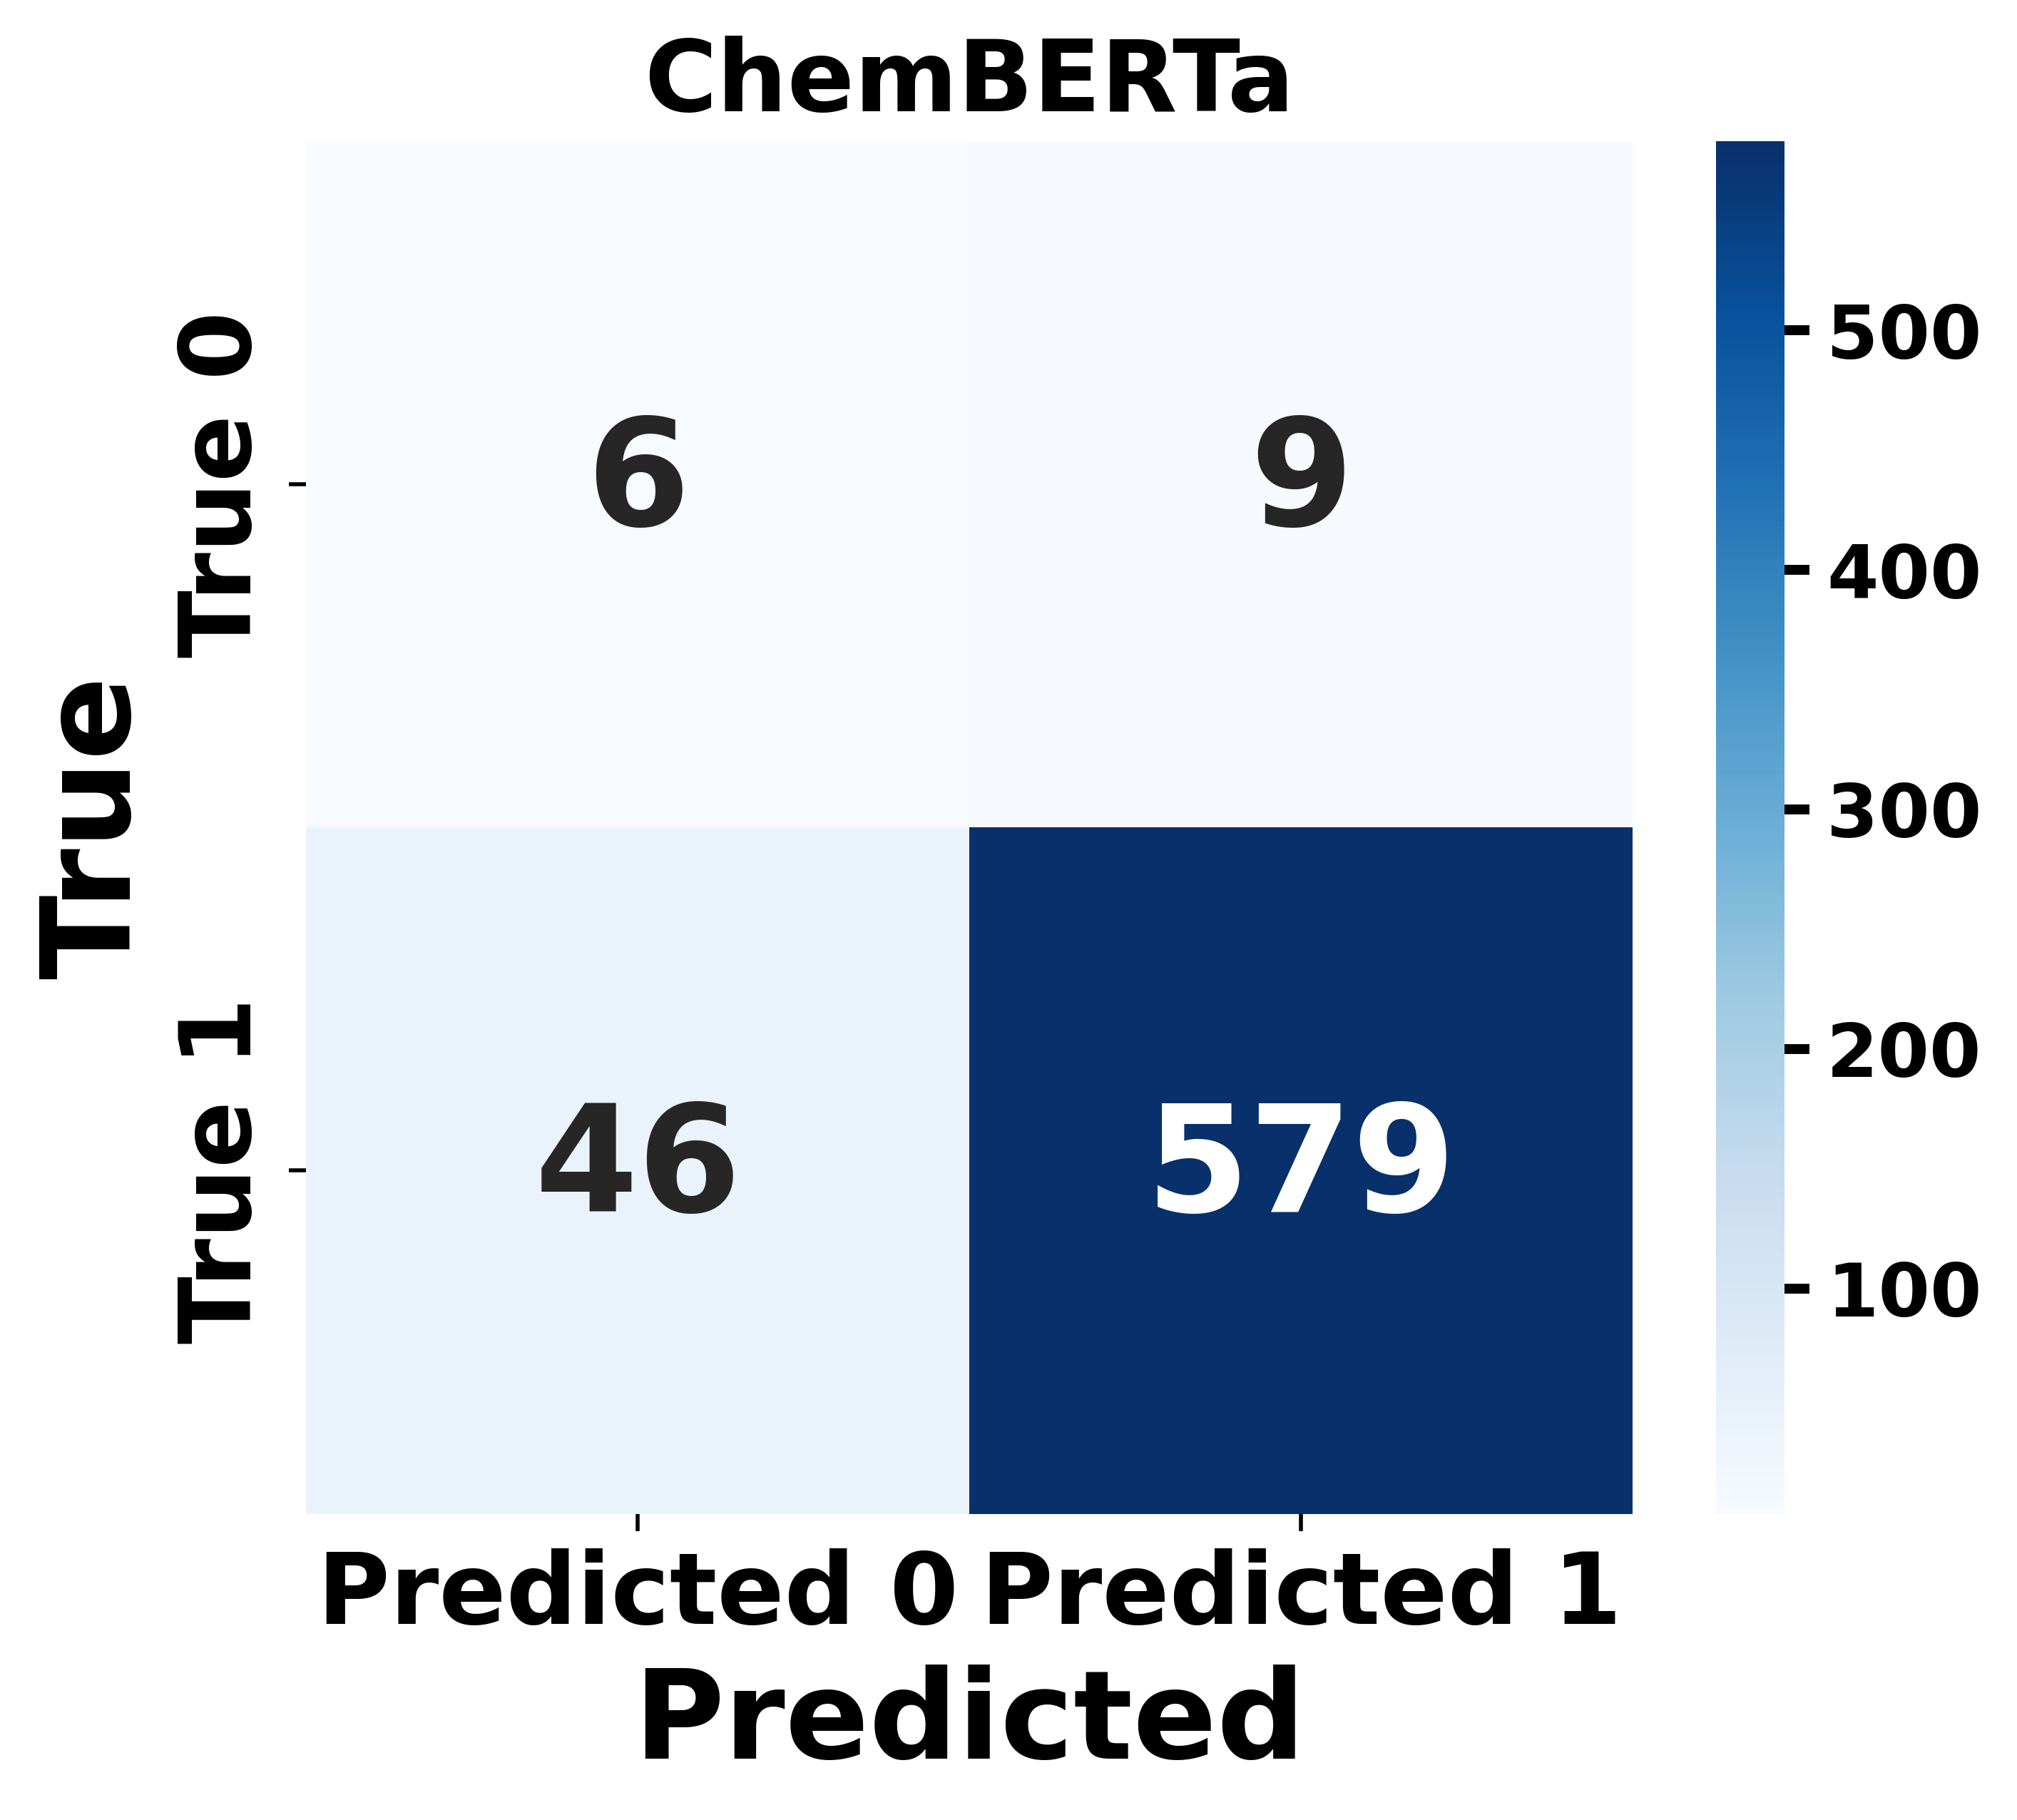

In [12]:

# 绘制热力图
plt.figure(figsize=(6, 5), dpi=500)
ax=sns.heatmap(
    conf_matrix_test, 
    annot=True, 
    fmt='d',
    annot_kws={'fontsize': 30, 'fontweight': 'bold'},  # 加粗数值
    cmap='Blues', 
    xticklabels=['Predicted 0', 'Predicted 1'], 
    yticklabels=['True 0', 'True 1']
)

# 设置标题和标签，并加粗字体
plt.title('ChemBERTa', fontsize=20, fontweight='bold')
plt.xlabel('Predicted', fontsize=25, fontweight='bold')
plt.ylabel('True', fontsize=25, fontweight='bold')

# 调整X/Y轴标签字体大小和加粗
plt.xticks(fontsize=20, fontweight='bold')  
plt.yticks(fontsize=20, fontweight='bold')  
    # 设置颜色条刻度字体加粗
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_tick_params(labelsize=15, width=2, length=5)
for label in cbar.ax.get_yticklabels():
    label.set_fontweight('bold')  # 让刻度标签加粗
#cbar.set_label("Accuracy", fontsize=20, fontweight='bold')  # 颜色条标题字体大小
# 显示图
plt.show()

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

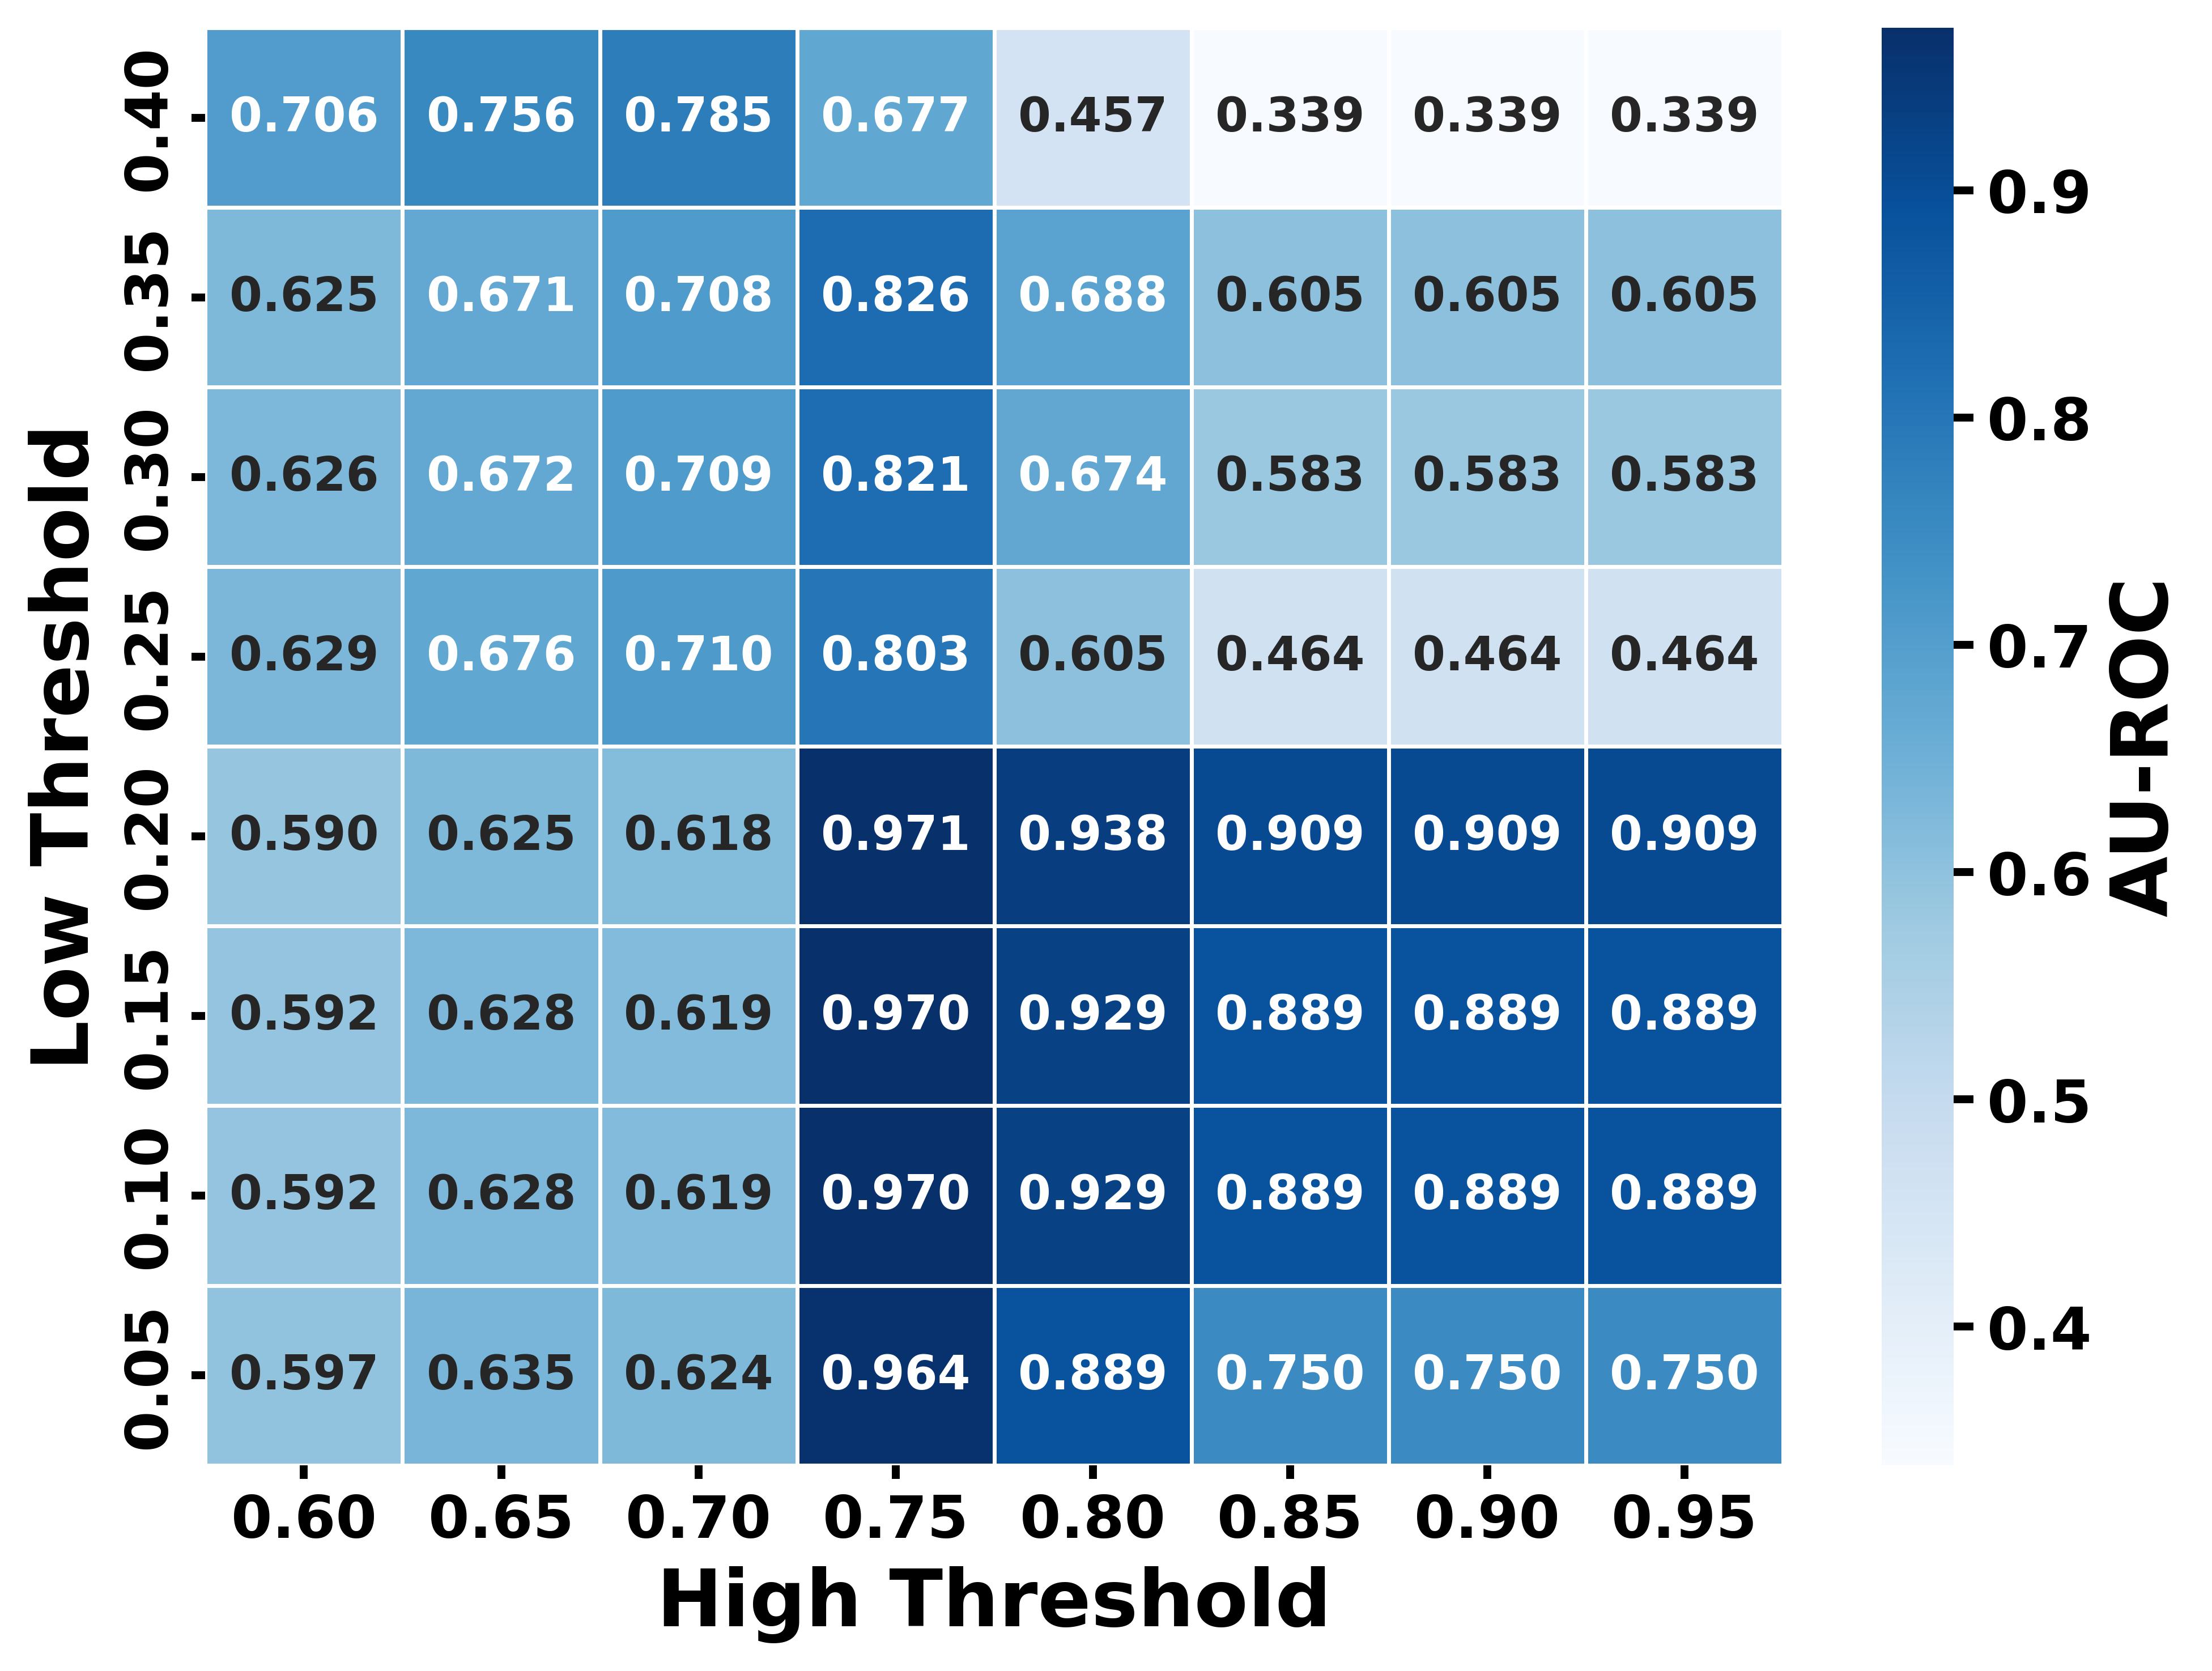

In [14]:
from sklearn.metrics import roc_auc_score

def plot_auroc(all_y_prob,all_y_true):


    # 设置上下界：low 从 0.2 到 0.4，每次步长 0.05，high 从 0.6 到 0.8，每次步长 0.05
    low_values = np.arange(0.05,0.41, 0.05)
    high_values = np.arange(0.6, 1, 0.05)

    # 用于保存每个 (low, high) 对应的 AUC-ROC
    auc_matrix = np.zeros((len(low_values), len(high_values)))

    # 对每个 (low, high) 组合，计算符合条件的样本数目和 AUC-ROC
    for i, low in enumerate(low_values):
        for j, high in enumerate(high_values):
            # 筛选出符合条件的样本
            valid_idx = np.where((all_y_prob <= low) | (all_y_prob >= high))[0]
            
            if len(valid_idx) > 0:  # 只有当 valid_idx 非空时才计算 AUC-ROC
                auc_score = roc_auc_score(all_y_true[valid_idx], all_y_prob[valid_idx])
            else:
                auc_score = np.nan  # 如果没有有效样本，设置为 0 或 NaN
            
            auc_matrix[i, j] = auc_score

    # 创建图形
    plt.figure(figsize=(8, 6), dpi=500)

    vmin = np.min(auc_matrix)  # 最小值)  # 最小值
    #vmax = np.max(accuracy_matrix) * 1.2 # 将最大值减少到最大值的95%
    vmax = np.max(auc_matrix)
    
    yanse = (vmax+vmin)/2

    # 创建带边框的热力图
    ax = sns.heatmap(
        auc_matrix,
        annot=True,              # 在格子中显示数值
        fmt=".3f",               # 保留3位小数
        cmap="Blues",            # 颜色表
        vmin=vmin, vmax=vmax,    # 颜色范围
        xticklabels=[f"{hv:.2f}" for hv in high_values],
        yticklabels=[f"{lv:.2f}" for lv in low_values],
        linewidths=1,            # 网格线宽度
        linecolor='white',       # 网格线颜色
        cbar_kws={"label": "AU-ROC"},  # 颜色条标签
        annot_kws={"size": 12, "weight": "bold"}
    )
    ax.invert_yaxis()
    # 设置坐标轴标签和字体大小
    ax.set_xlabel("High Threshold", fontsize=20,fontweight='bold')
    ax.set_ylabel("Low Threshold", fontsize=20,fontweight='bold')
    ax.tick_params(labelsize=15, width=2)
    # **设置坐标轴刻度字体加粗**
    for label in ax.get_xticklabels():
        label.set_fontweight('bold')
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')
    # 调整颜色条的字体大小
    cbar = ax.collections[0].colorbar
    #cbar.ax.tick_params(labelsize=15, width=3)  # 设置颜色条刻度字体大小
    # 设置颜色条刻度字体加粗
    cbar.ax.yaxis.set_tick_params(labelsize=15, width=2, length=5)
    for label in cbar.ax.get_yticklabels():
        label.set_fontweight('bold')  # 让刻度标签加粗
    cbar.set_label("AU-ROC", fontsize=20, fontweight='bold')  # 颜色条标题字体大小
    # 显示图
    plt.tight_layout()
    plt.show()



# 调用函数进行五折交叉验证并绘图
plot_auroc(all_fold_probs,all_fold_labels)


In [15]:
# all_fold_preds.append(all_preds)
# all_fold_probs.append(all_probs)
# all_fold_labels.append(all_labels)

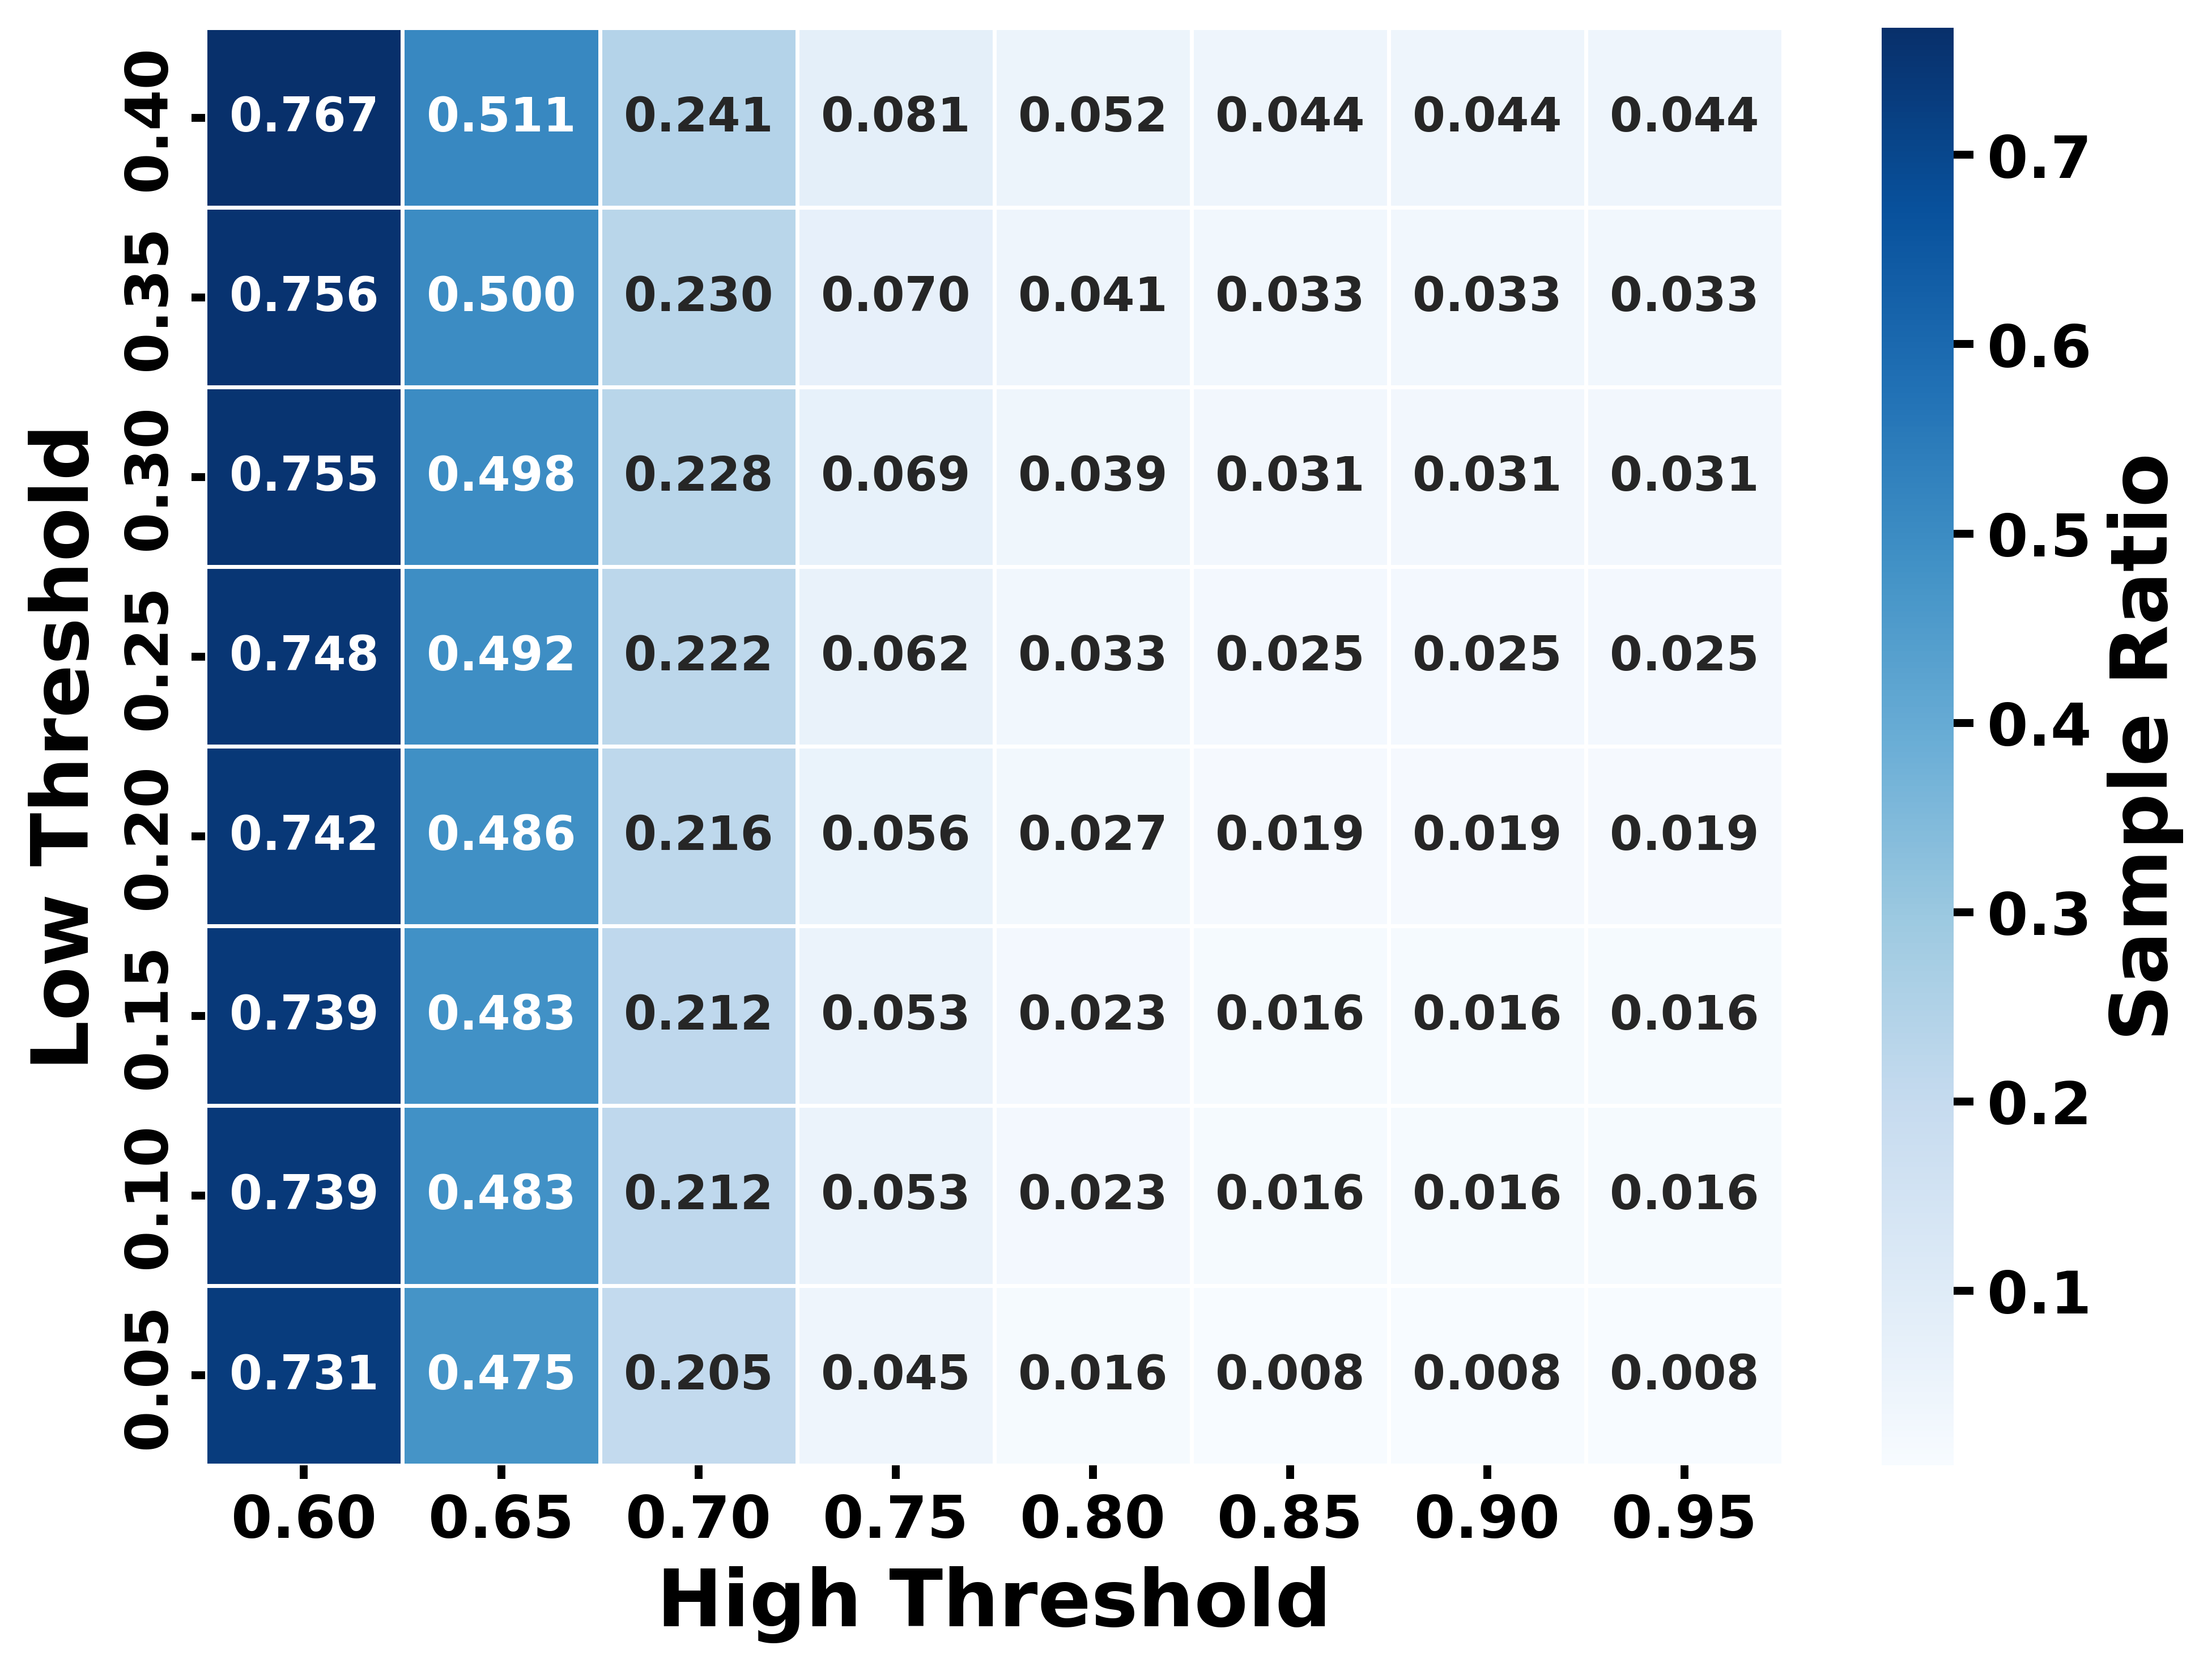

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

def plot_ratio(all_y_prob,all_y_true):


    # 设置上下界：low 从 0.2 到 0.4，每次步长 0.05，high 从 0.6 到 0.8，每次步长 0.05
    low_values = np.arange(0.05,0.41, 0.05)
    high_values = np.arange(0.6, 1, 0.05)
    # 用于保存每个 (low, high) 对应的样本占比
    sample_ratio_matrix = np.zeros((len(low_values), len(high_values)))

    # 对每个 (low, high) 组合，计算符合条件的样本占比
    for i, low in enumerate(low_values):
        for j, high in enumerate(high_values):
            # 筛选出符合条件的样本
            valid_idx = np.where((all_y_prob <= low) | (all_y_prob >= high))[0]
            
            if len(valid_idx) > 0:  # 只有当 valid_idx 非空时才计算样本占比
                sample_ratio = len(valid_idx) / len(all_y_true)
            else:
                sample_ratio = 0  # 如果没有有效样本，设置为 0
            
            sample_ratio_matrix[i, j] = sample_ratio

    # 创建图形
    plt.figure(figsize=(8, 6), dpi=500)

    vmin = np.min(sample_ratio_matrix)  # 最小值)  # 最小值
    #vmax = np.max(accuracy_matrix) * 1.2 # 将最大值减少到最大值的95%
    vmax = np.max(sample_ratio_matrix)
    yanse = (vmax+vmin)/2

    

    # 创建带边框的热力图
    ax = sns.heatmap(
        sample_ratio_matrix,
        annot=True,              # 在格子中显示数值
        fmt=".3f",               # 保留3位小数
        cmap="Blues",            # 颜色表
        vmin=vmin, vmax=vmax,    # 颜色范围
        xticklabels=[f"{hv:.2f}" for hv in high_values],
        yticklabels=[f"{lv:.2f}" for lv in low_values],
        linewidths=1,            # 网格线宽度
        linecolor='white',       # 网格线颜色
        cbar_kws={"label": "Sample Ratio"},  # 颜色条标签
        annot_kws={"size": 12, "weight": "bold"}
    )
    ax.invert_yaxis()
    # 设置坐标轴标签和字体大小
    ax.set_xlabel("High Threshold", fontsize=20,fontweight='bold')
    ax.set_ylabel("Low Threshold", fontsize=20,fontweight='bold')
    ax.tick_params(labelsize=15, width=2)
    # **设置坐标轴刻度字体加粗**
    for label in ax.get_xticklabels():
        label.set_fontweight('bold')
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')
    # 调整颜色条的字体大小
    cbar = ax.collections[0].colorbar
    #cbar.ax.tick_params(labelsize=15, width=3)  # 设置颜色条刻度字体大小
    # 设置颜色条刻度字体加粗
    cbar.ax.yaxis.set_tick_params(labelsize=15, width=2, length=5)
    for label in cbar.ax.get_yticklabels():
        label.set_fontweight('bold')  # 让刻度标签加粗
    cbar.set_label("Sample Ratio", fontsize=20, fontweight='bold')  # 颜色条标题字体大小
    # 显示图
    plt.tight_layout()
    plt.show()



# 调用函数进行五折交叉验证并绘图
plot_ratio(all_fold_probs,all_fold_labels)


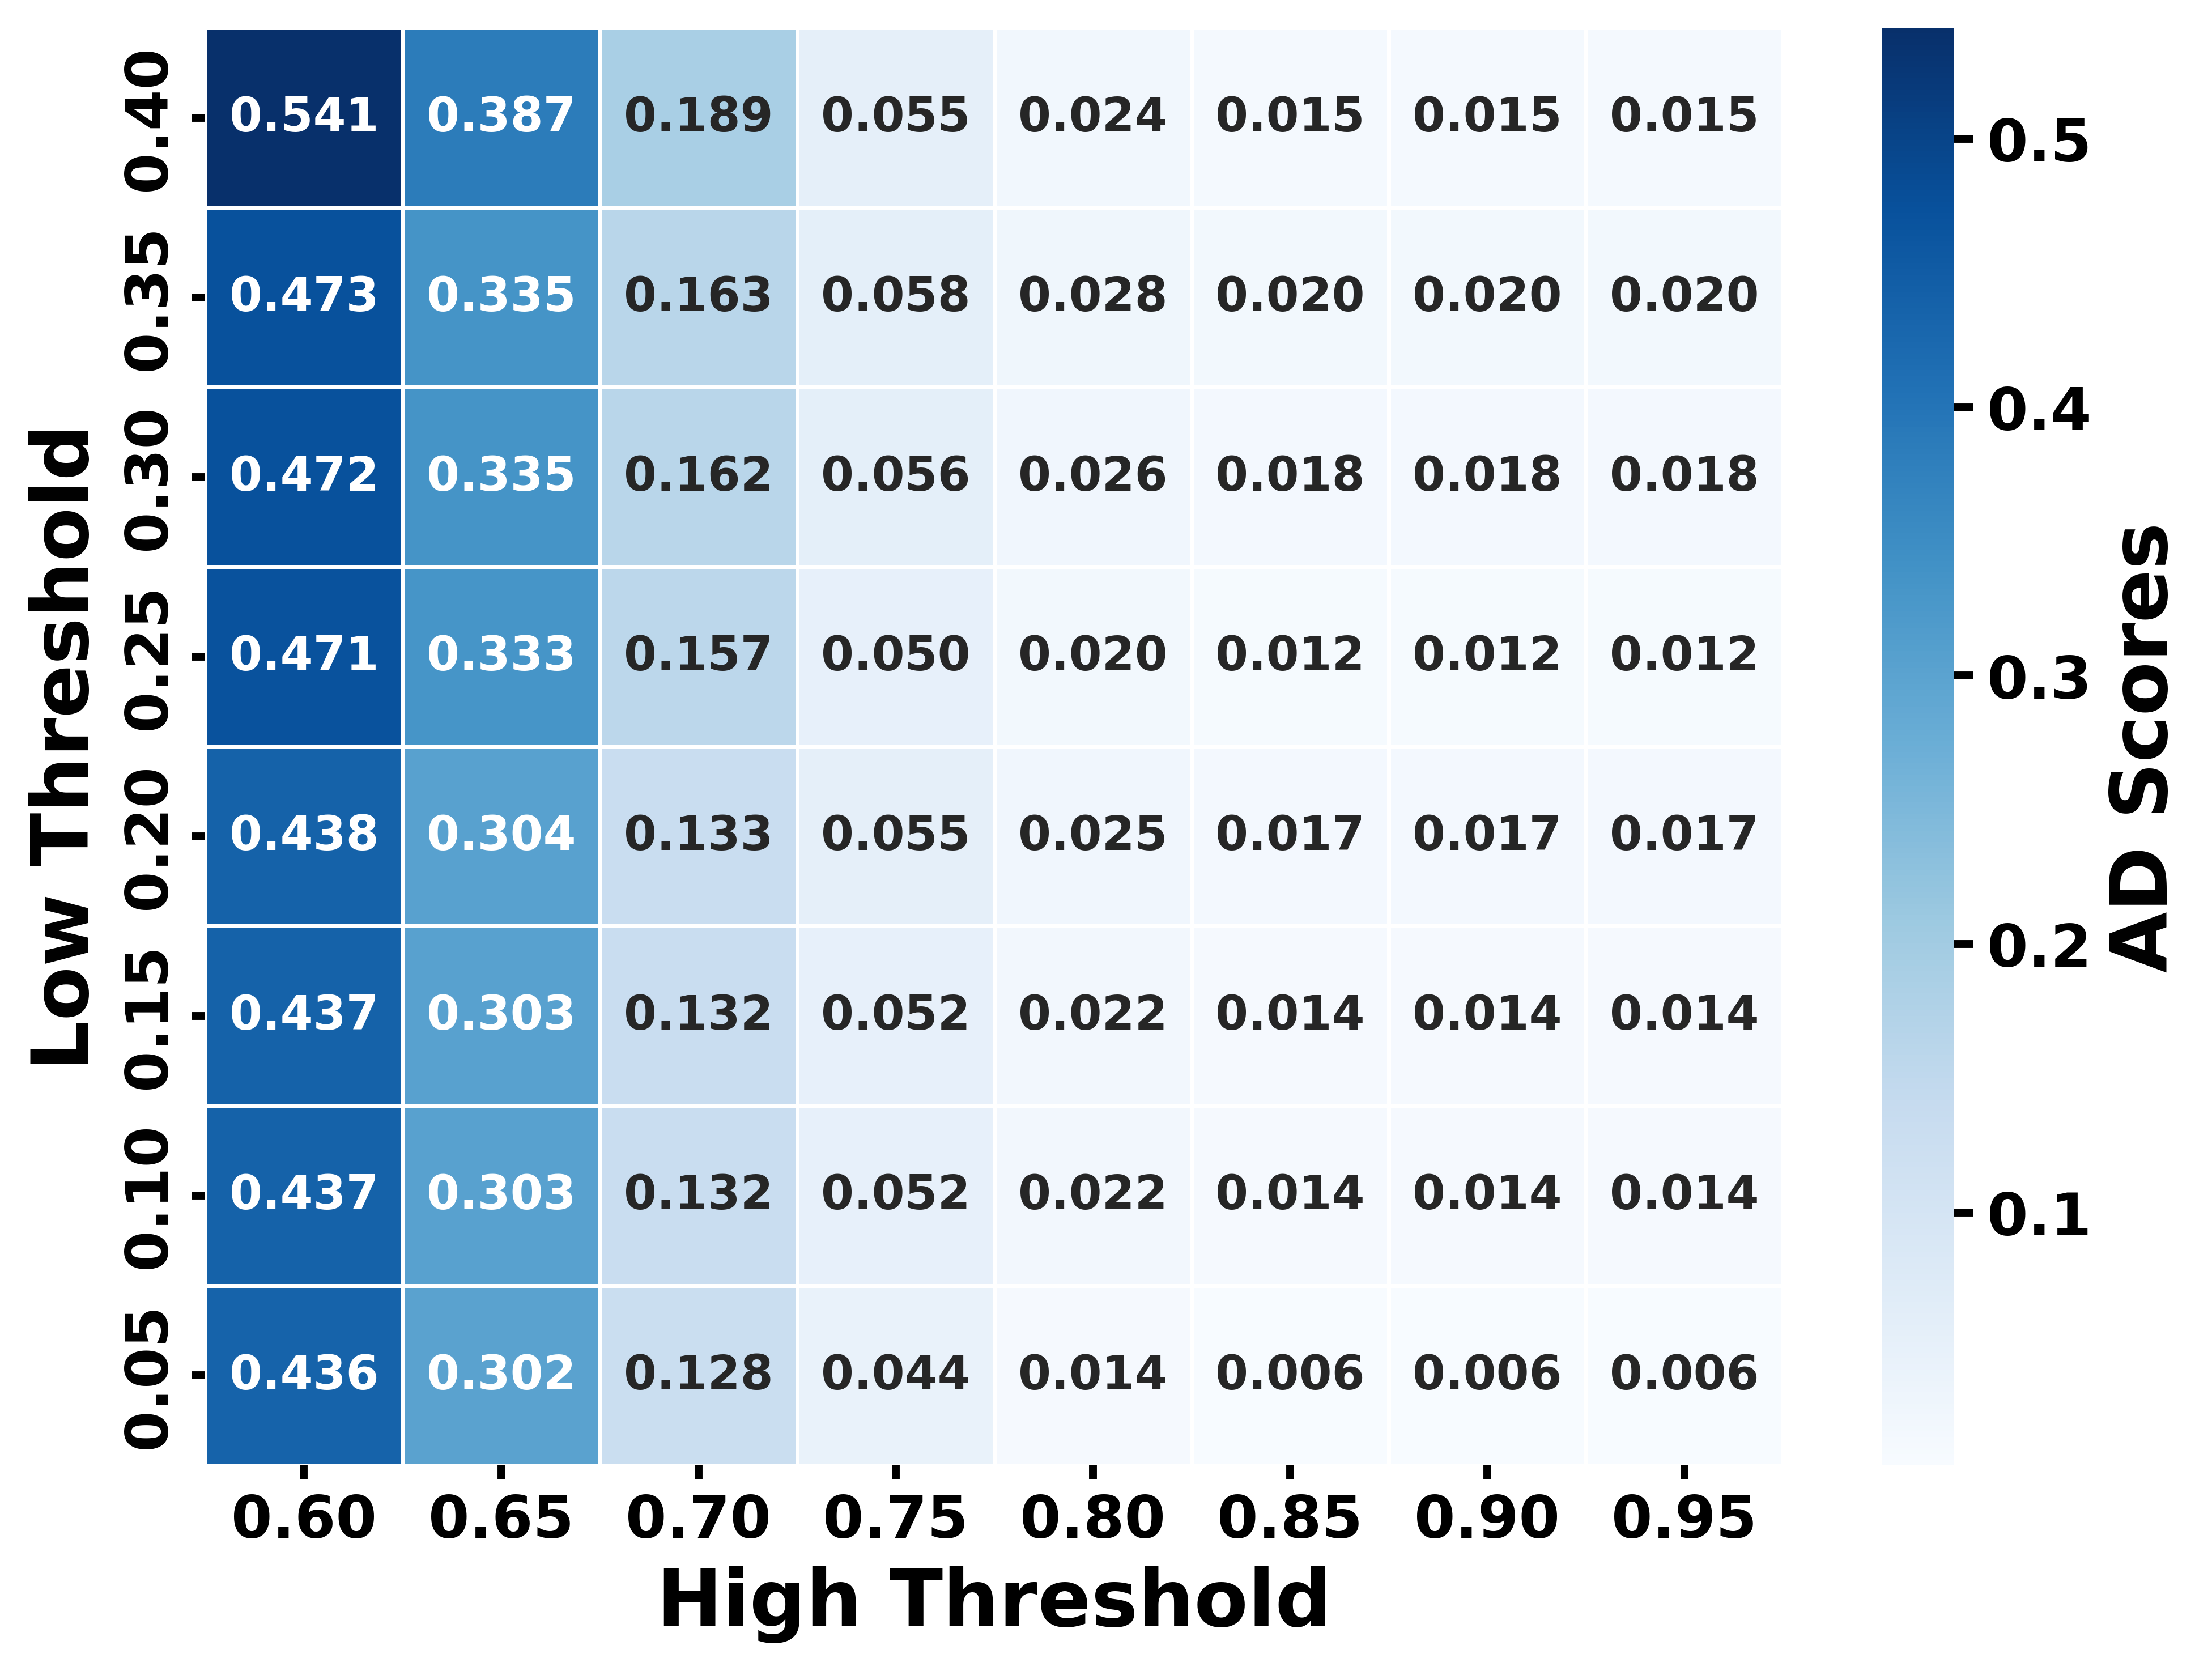

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

def plot_ADS(all_y_prob,all_y_true):


    # 设置上下界：low 从 0.2 到 0.4，每次步长 0.05，high 从 0.6 到 0.8，每次步长 0.05
    low_values = np.arange(0.05,0.41, 0.05)
    high_values = np.arange(0.6, 1, 0.05)

    # 用于保存每个 (low, high) 对应的样本占比
    sample_ratio_matrix = np.zeros((len(low_values), len(high_values)))

    # 对每个 (low, high) 组合，计算符合条件的样本占比
    for i, low in enumerate(low_values):
        for j, high in enumerate(high_values):
            # 筛选出符合条件的样本
            valid_idx = np.where((all_y_prob <= low) | (all_y_prob >= high))[0]
            
            if len(valid_idx) > 0:  # 只有当 valid_idx 非空时才计算样本占比
                sample_ratio = len(valid_idx) / len(all_y_true)
            else:
                sample_ratio = 0  # 如果没有有效样本，设置为 0
            
            sample_ratio_matrix[i, j] = sample_ratio

        # 用于保存每个 (low, high) 对应的 AUC-ROC
    auc_matrix = np.zeros((len(low_values), len(high_values)))

    # 对每个 (low, high) 组合，计算符合条件的样本数目和 AUC-ROC
    for i, low in enumerate(low_values):
        for j, high in enumerate(high_values):
            # 筛选出符合条件的样本
            valid_idx = np.where((all_y_prob <= low) | (all_y_prob >= high))[0]
            
            if len(valid_idx) > 0:  # 只有当 valid_idx 非空时才计算 AUC-ROC
                auc_score = roc_auc_score(all_y_true[valid_idx], all_y_prob[valid_idx])
            else:
                auc_score = np.nan  # 如果没有有效样本，设置为 0 或 NaN
            
            auc_matrix[i, j] = auc_score

    matrix = auc_matrix*sample_ratio_matrix
    
    # 创建图形
    plt.figure(figsize=(8, 6), dpi=500)

    vmin = np.min(matrix)  # 最小值)  # 最小值
    #vmax = np.max(accuracy_matrix) * 1.2 # 将最大值减少到最大值的95%
    vmax = np.max(matrix) 
    yanse = (vmax+vmin)/2

    

    # 创建带边框的热力图
    ax = sns.heatmap(
        matrix,
        annot=True,              # 在格子中显示数值
        fmt=".3f",               # 保留3位小数
        cmap="Blues",            # 颜色表
        vmin=vmin, vmax=vmax,    # 颜色范围
        xticklabels=[f"{hv:.2f}" for hv in high_values],
        yticklabels=[f"{lv:.2f}" for lv in low_values],
        linewidths=1,            # 网格线宽度
        linecolor='white',       # 网格线颜色
        cbar_kws={"label": "Sample Ratio"},  # 颜色条标签
        annot_kws={"size": 12, "weight": "bold"}
    )
    ax.invert_yaxis()
    # 设置坐标轴标签和字体大小
    ax.set_xlabel("High Threshold", fontsize=20,fontweight='bold')
    ax.set_ylabel("Low Threshold", fontsize=20,fontweight='bold')
    ax.tick_params(labelsize=15, width=2)
    # **设置坐标轴刻度字体加粗**
    for label in ax.get_xticklabels():
        label.set_fontweight('bold')
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')
    # 调整颜色条的字体大小
    cbar = ax.collections[0].colorbar
    #cbar.ax.tick_params(labelsize=15, width=3)  # 设置颜色条刻度字体大小
    # 设置颜色条刻度字体加粗
    cbar.ax.yaxis.set_tick_params(labelsize=15, width=2, length=5)
    for label in cbar.ax.get_yticklabels():
        label.set_fontweight('bold')  # 让刻度标签加粗
    cbar.set_label("AD Scores", fontsize=20, fontweight='bold')  # 颜色条标题字体大小
    # 显示图
    plt.tight_layout()
    plt.show()




# 调用函数进行五折交叉验证并绘图
plot_ADS(all_fold_probs,all_fold_labels)